# Contents

>[Contents](#scrollTo=ISfvEc6QTF3-)

>[Imports and Setup](#scrollTo=LzQFZNKL0uHb)

>[Create the Sphere Mesh](#scrollTo=ToNMP7mC797Y)

>[Create the renderer](#scrollTo=avCqYaNn8fi7)

>[Create a basic ML model](#scrollTo=NOyG2PbN-NXI)

>>[Helper functions](#scrollTo=PwjQaIA9SNSS)

>>[Train and test loops](#scrollTo=_McEInbeBvJR)

>[Experiments - color optimization (initial gradient color)](#scrollTo=0ni9zstuIsfs)

>>[Optimizing only the weights (baseline)](#scrollTo=lAuhSR-TSelq)

>>[Optimizing the colors and the weights simultaneously](#scrollTo=aZLeUrEfSDlY)

>[Experiments - color optimization (monochrome initial color)](#scrollTo=VUlpgyWFIcvF)

>>[Optimizing only the weights](#scrollTo=yJRkbLR-IiYr)

>>[Optimizing the colors and the weights simultaneously](#scrollTo=lfcblmj7KaYb)

>[Experiments - shape optimization](#scrollTo=bhN4Vw7UA43V)

>>[Optimizing the shape and the weights simultaneously](#scrollTo=2Oy6BEHMCIsM)

>>[Optimizing the shape and the weights simultaneously with smoothing](#scrollTo=lZ7-6V56CBLs)

>[Experiments - color and shape optimization](#scrollTo=N4UWNZa2NbJU)

>>[Optimizing the colors, shape and weights simultaneously](#scrollTo=HKp6KakzNgRz)

>>[Optimizing the colors, shape and weights simultaneously with smoothing](#scrollTo=cEkXMAViRbhs)



# Imports and Setup

In [ ]:
!pip install ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 24.2 MB/s eta 0:00:00


In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.2.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-a20is_qd
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-a20is_qd
  Running command git checkout -q 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.8-cp311-cp311-linux_x86_64.whl size=59756801 sha256=8ba1cd7f7415fe7691ea462ac67907e520ac1b807b1890513961f968d8fe3118
  Stored in directory: /tmp/pip-ephem-wheel-cache-uzuzka5j/wheels/08/90/1b/df18c3e3634f86278e793b87f37ea4c58d0c36731196122518
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=7050400c1790b1f19b6c275

In [ ]:
import os
import torch
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.transforms import Rotate, Translate, RotateAxisAngle
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)
from pytorch3d.loss import mesh_laplacian_smoothing

import torch
import torch.nn as nn
import torch.optim as optim

# Create the Sphere Mesh

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()
verts_min = verts.min(dim=0, keepdim=True)[0]
verts_max = verts.max(dim=0, keepdim=True)[0]
normalized_verts = (verts - verts_min) / (verts_max - verts_min)

vertex_colors = nn.Parameter(normalized_verts.unsqueeze(0))
textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

# Create the renderer
The renderer needs a rasterizer and a shader.

In [ ]:
image_size = 128

In [ ]:
cameras = FoVPerspectiveCameras(
  device=device,
  T=torch.tensor([[0.0, 0.0, 3.0]], device=device)
)

raster_settings = RasterizationSettings(
  image_size = image_size,
  blur_radius = 0.0,
  faces_per_pixel = 1,
)
lights = PointLights(device = device, location=[[0.0, 0.0, -3.0]])

renderer = MeshRenderer(
  rasterizer = MeshRasterizer(
    cameras=cameras,
    raster_settings=raster_settings
  ),
  shader = HardPhongShader(
    device = device,
    cameras=cameras,
    lights=lights
  )
)

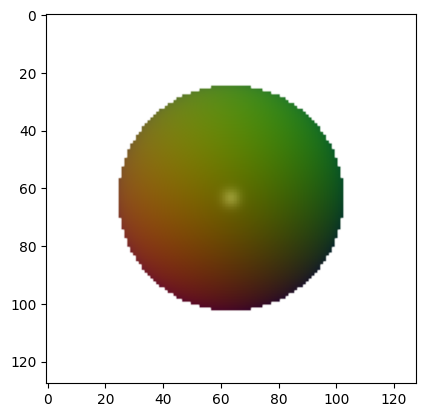

In [ ]:
image = renderer(sphere_mesh, cameras=cameras, lights=lights)
plt.imshow(image[0, ..., :].detach().cpu().numpy())

# Create a basic ML model

In [ ]:
class RotationPredictor(nn.Module):
    def __init__(self):
        super(RotationPredictor, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.contiguous().view(-1, 128 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Helper functions
We also need some helper functions for rotating and visualizing the spheres while training.

In [ ]:
def create_rotated_sphere(sphere_mesh, angle_degrees, device):
  angle = torch.tensor([angle_degrees * np.pi / 180.0], device=device)

  rot_y = torch.tensor([[torch.cos(angle), 0, torch.sin(angle)],
                        [0, 1, 0],
                        [-torch.sin(angle), 0, torch.cos(angle)]], device=device)

  rotated_verts = sphere_mesh.verts_packed() @ rot_y.T

  rotated_mesh = Meshes(
    verts=[rotated_verts],
    faces=[sphere_mesh.faces_packed()],
    textures=sphere_mesh.textures
  )

  return rotated_mesh

In [ ]:
def visualize_sphere(sphere_mesh, vertex_colors, renderer, cameras, lights):
  with torch.no_grad():
    num_verts = sphere_mesh.verts_packed().shape[0]

    vertex_colors_vis = vertex_colors.clone().detach()
    vertex_colors_vis = vertex_colors_vis.reshape(1, num_verts, 3)

    textures = TexturesVertex(verts_features=vertex_colors_vis)

    vis_mesh = Meshes(
        verts=[sphere_mesh.verts_packed()],
        faces=[sphere_mesh.faces_packed()],
        textures=textures
    )

    image = renderer(vis_mesh, cameras=cameras, lights=lights)
    plt.figure(figsize=(5, 5))
    plt.imshow(image[0, ..., :3].cpu().numpy())
    plt.axis('off')
    plt.show()


## Train and test loops

In [ ]:
def train_model(model, optimizer, mesh, vertex_colors, renderer, cameras, lights, num_epochs=500, batch_size=32, lr=0.001, criterion=nn.MSELoss(), use_smoothing_loss=False):
  losses = []
  for epoch in range(num_epochs):
    total_loss = 0

    for i in range(batch_size):
      optimizer.zero_grad()

      textures = TexturesVertex(verts_features=vertex_colors.clone())
      mesh.textures = textures
      angle = np.random.randint(0, 360)
      rotated_sphere = create_rotated_sphere(mesh, angle, device)

      image = renderer(rotated_sphere, cameras=cameras, lights=lights)
      image = image[..., :3].contiguous().permute(0, 3, 1, 2)

      predicted_angle = model(image)
      target_angle = torch.tensor([[angle * np.pi / 180.0]], device=device)

      loss = criterion(predicted_angle, target_angle)
      if use_smoothing_loss:
          loss += mesh_laplacian_smoothing(mesh, method="uniform")  # Add weight to the smoothing loss? How much?

      loss.backward()

      total_loss += loss.item()

    avg_epoch_loss = total_loss / batch_size
    losses.append(avg_epoch_loss)
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
        visualize_sphere(mesh, vertex_colors, renderer, cameras, lights)

  return losses

In [ ]:
def test_model(model, sphere_mesh, renderer, cameras, lights, num_tests=500):
  total_squared_error = 0
  with torch.no_grad():
    for i in range(num_tests):
      angle = np.random.randint(0, 360)
      rotated_sphere = create_rotated_sphere(sphere_mesh, angle, device)

      image = renderer(rotated_sphere, cameras=cameras, lights=lights)
      image = image[..., :3].contiguous().permute(0, 3, 1, 2)

      predicted_angle = model(image)

      predicted_angle_degrees = predicted_angle.item() * 180 / np.pi
      squared_error = (angle - predicted_angle_degrees) ** 2
      total_squared_error += squared_error

  mse = np.sqrt(total_squared_error / num_tests)
  return mse


# Experiments - color optimization (initial gradient color)

## Optimizing only the weights (baseline)

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()
verts_min = verts.min(dim=0, keepdim=True)[0]
verts_max = verts.max(dim=0, keepdim=True)[0]
normalized_verts = (verts - verts_min) / (verts_max - verts_min)

vertex_colors = nn.Parameter(normalized_verts.unsqueeze(0))
textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

optimizer = optim.Adam([
    {'params': model.parameters()}
], lr=0.001)

criterion = nn.MSELoss()

Epoch [100/2500], Loss: 0.6751


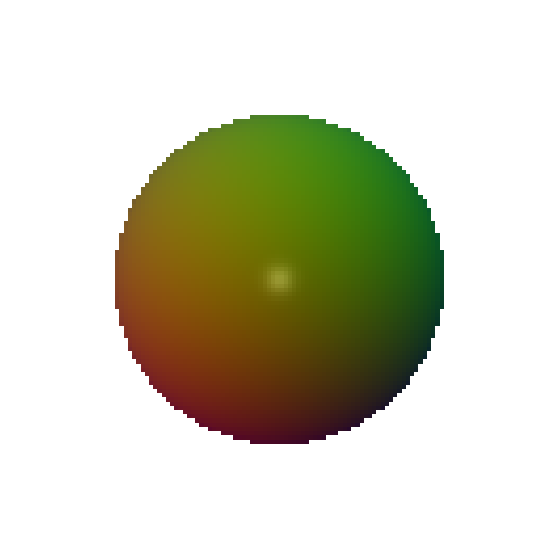

Epoch [200/2500], Loss: 1.8406


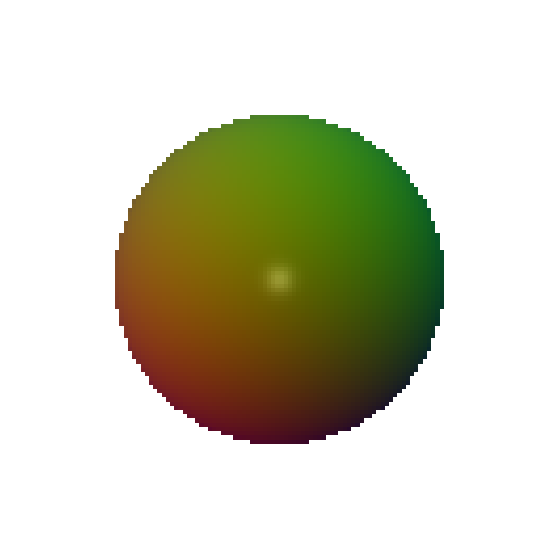

Epoch [300/2500], Loss: 0.9505


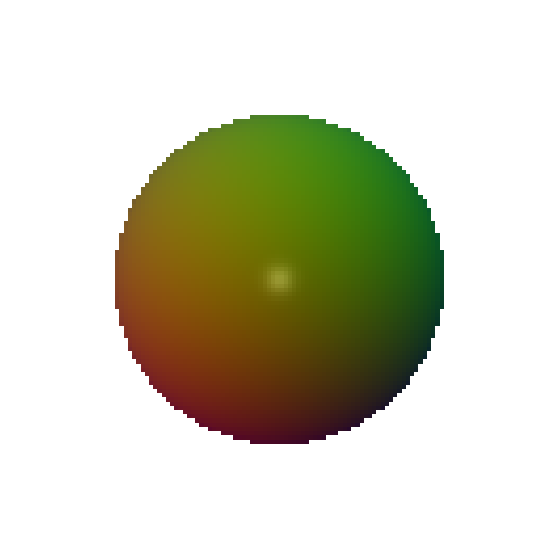

Epoch [400/2500], Loss: 0.4974


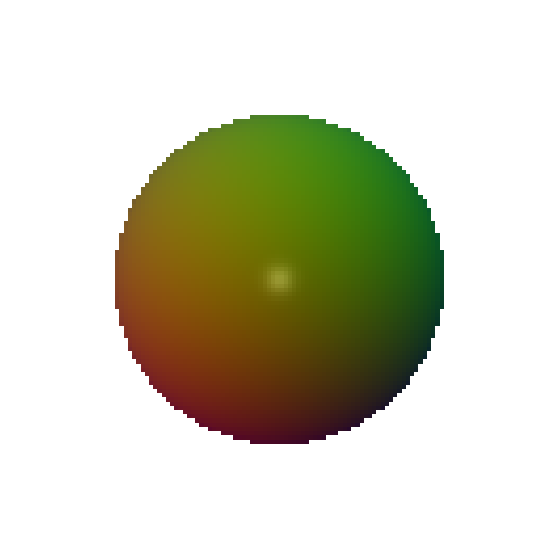

Epoch [500/2500], Loss: 1.3467


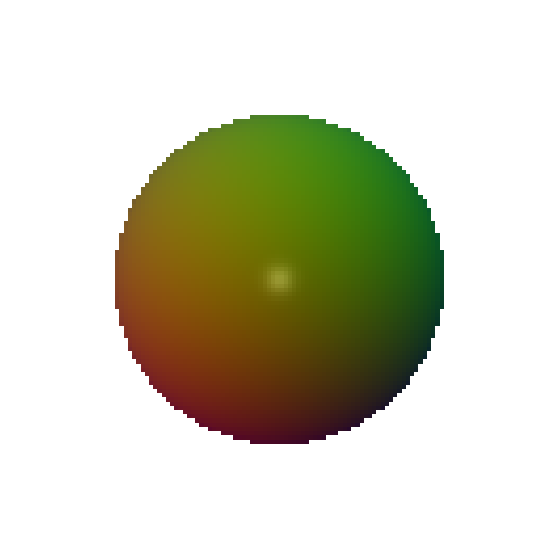

Epoch [600/2500], Loss: 0.6859


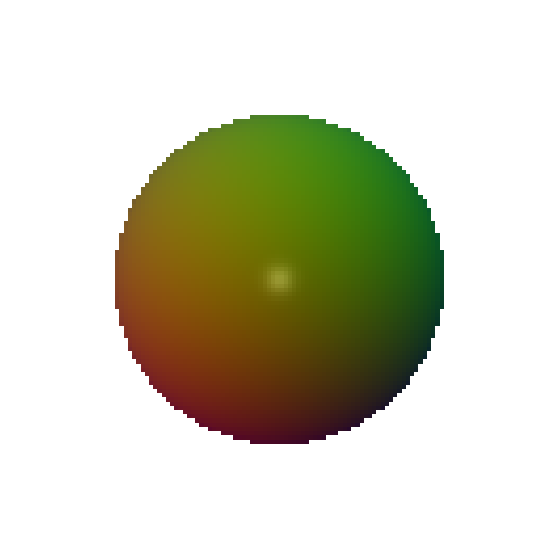

Epoch [700/2500], Loss: 2.1188


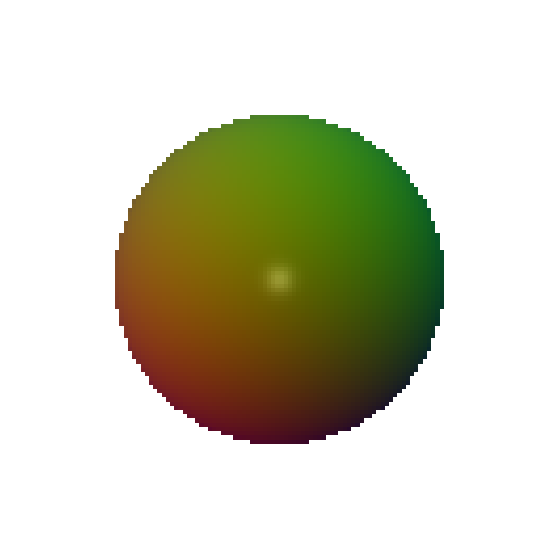

Epoch [800/2500], Loss: 0.4048


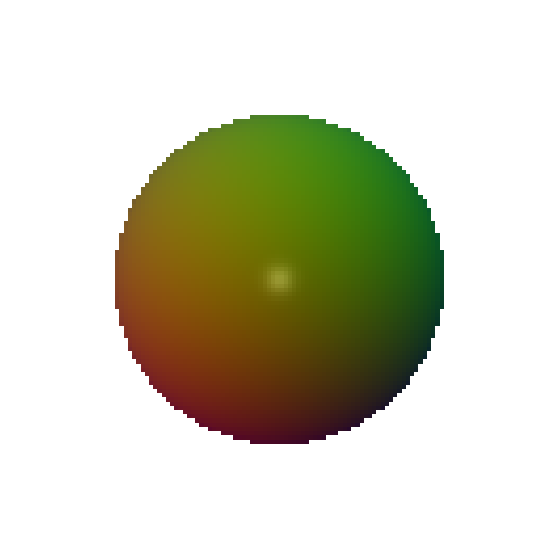

Epoch [900/2500], Loss: 2.0983


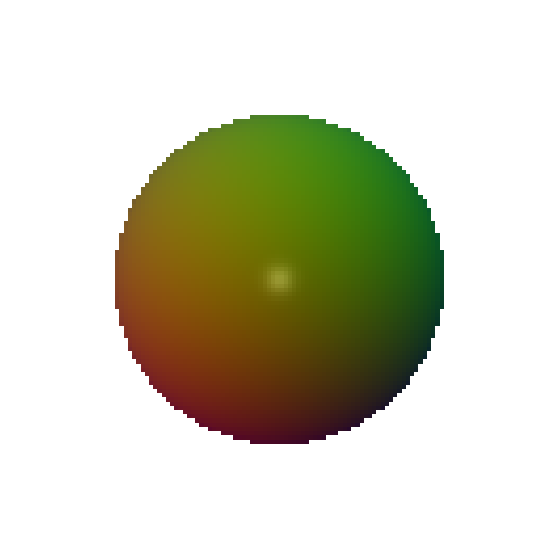

Epoch [1000/2500], Loss: 0.0873


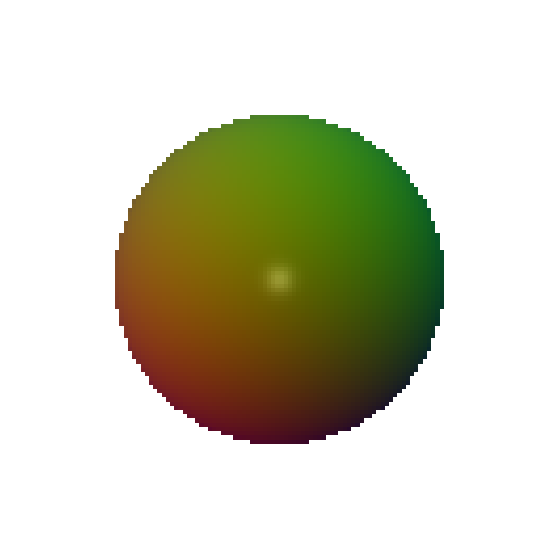

Epoch [1100/2500], Loss: 1.2332


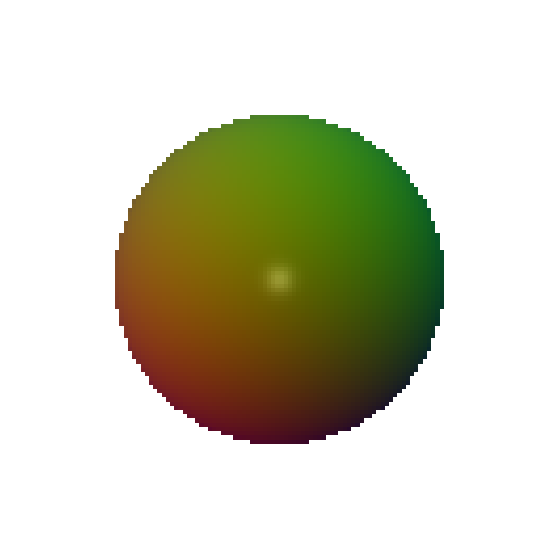

Epoch [1200/2500], Loss: 0.9954


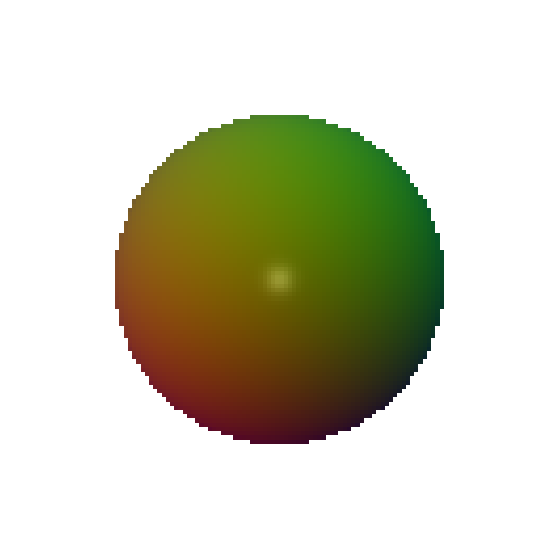

Epoch [1300/2500], Loss: 0.0535


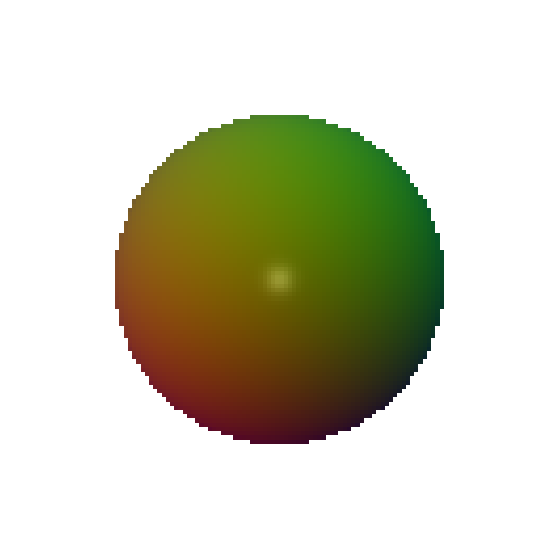

Epoch [1400/2500], Loss: 0.0623


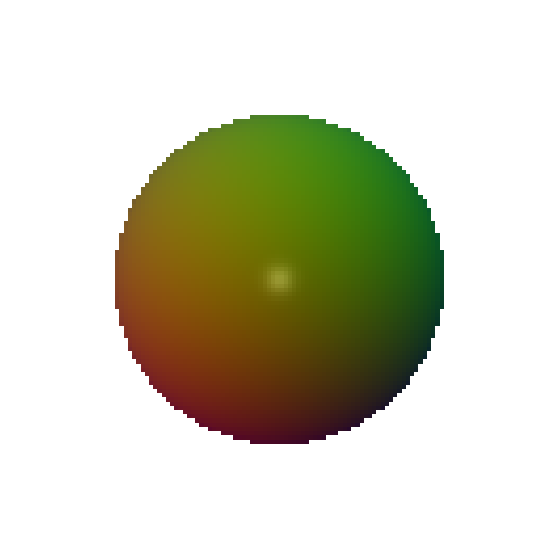

Epoch [1500/2500], Loss: 0.4960


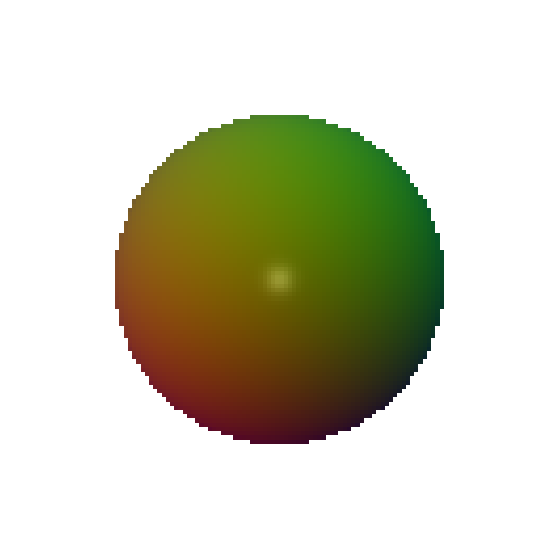

Epoch [1600/2500], Loss: 0.5061


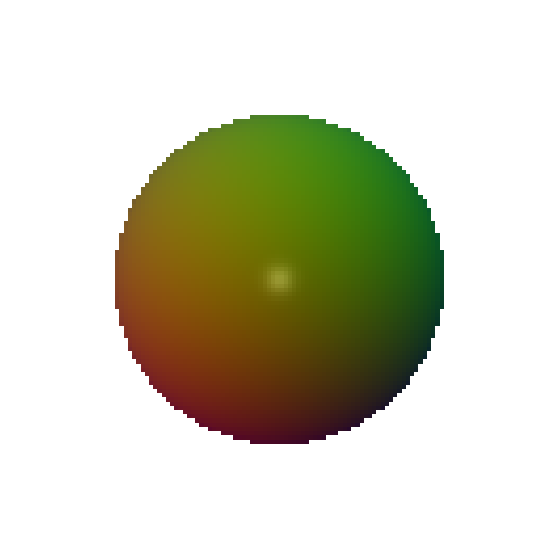

Epoch [1700/2500], Loss: 0.0073


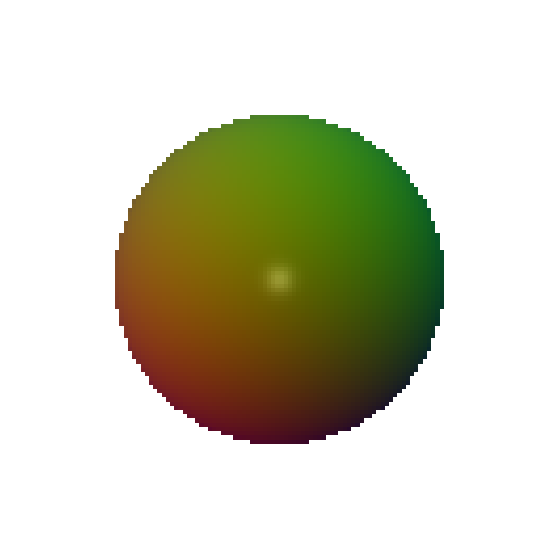

Epoch [1800/2500], Loss: 1.6444


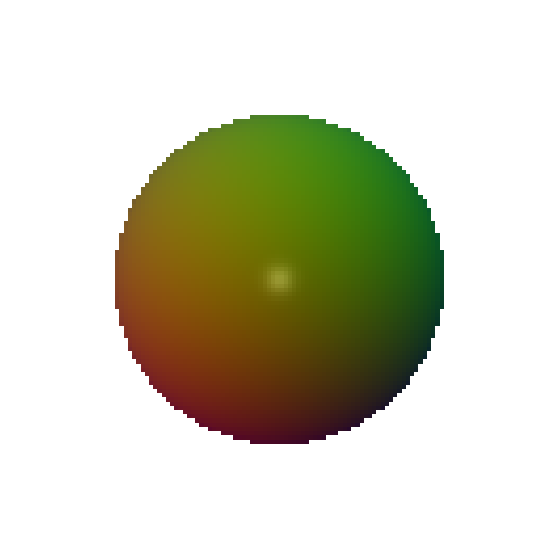

Epoch [1900/2500], Loss: 0.2043


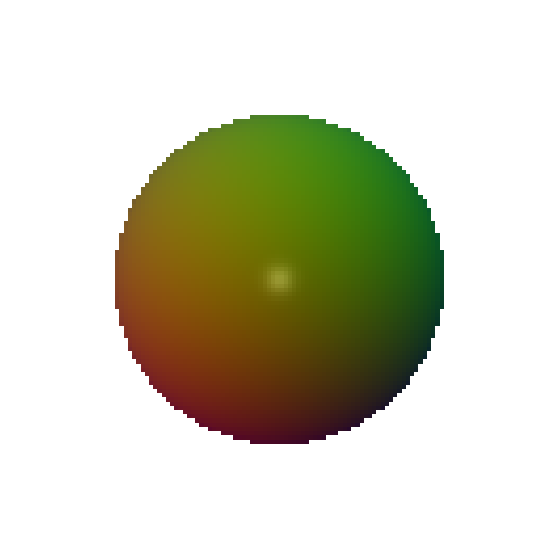

Epoch [2000/2500], Loss: 0.6727


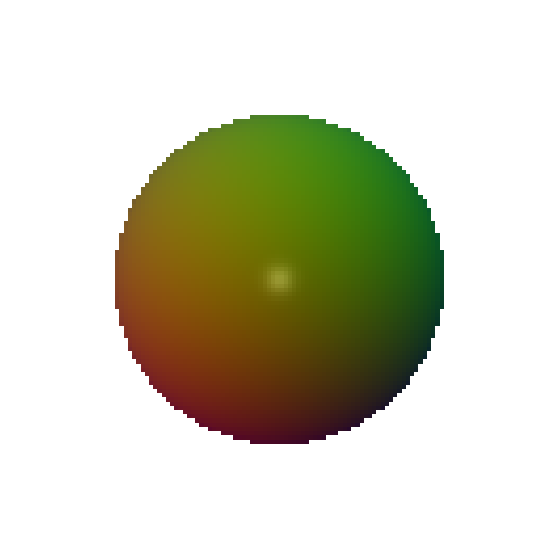

Epoch [2100/2500], Loss: 0.4140


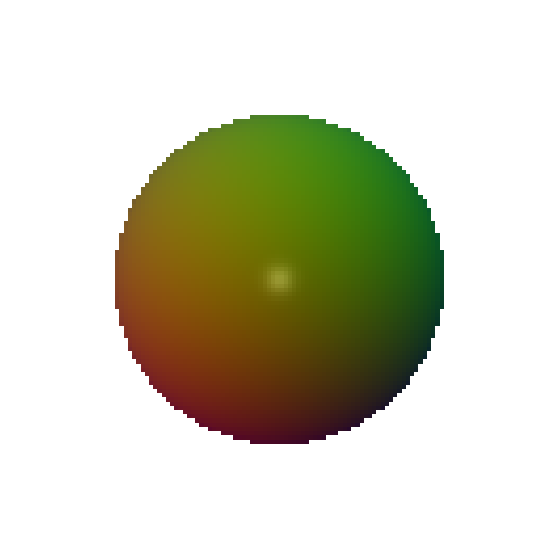

Epoch [2200/2500], Loss: 1.9284


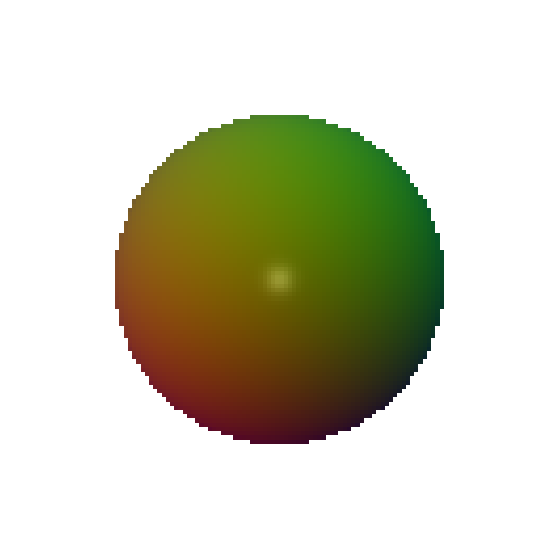

Epoch [2300/2500], Loss: 0.0481


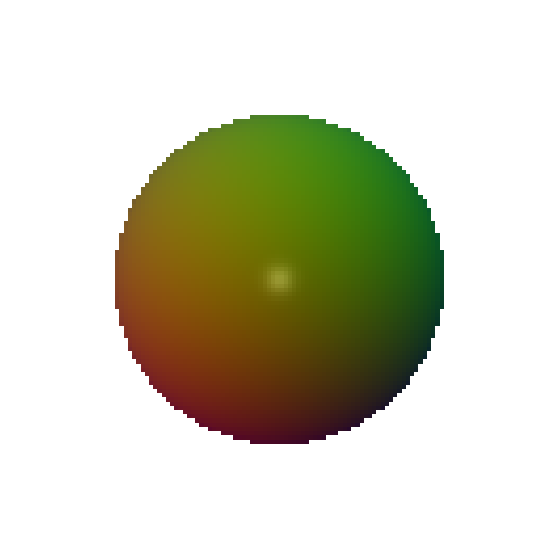

Epoch [2400/2500], Loss: 0.0249


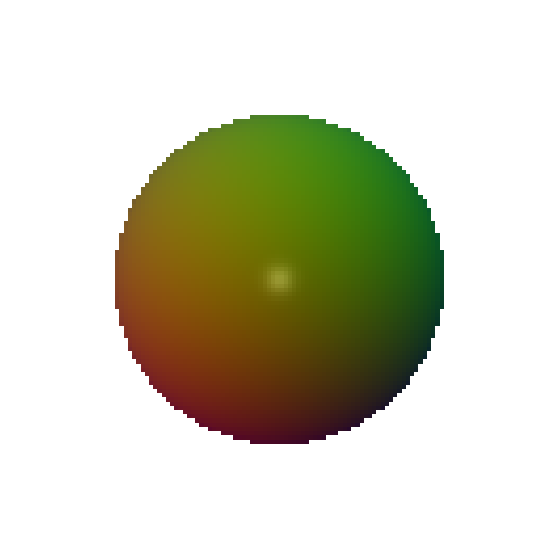

Epoch [2500/2500], Loss: 0.5169


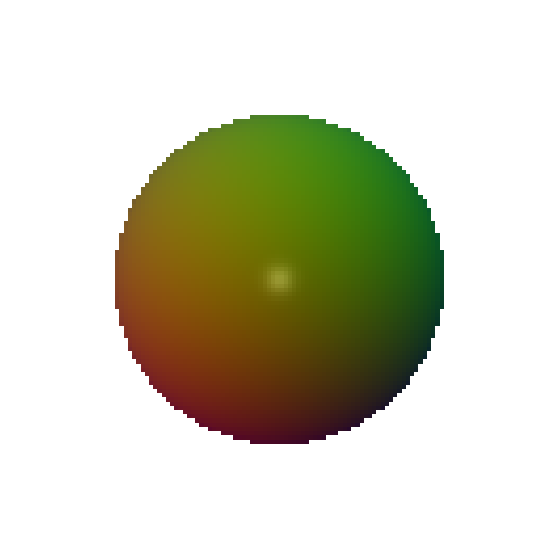

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, vertex_colors, renderer, cameras, lights, num_epochs=2500, batch_size=16)

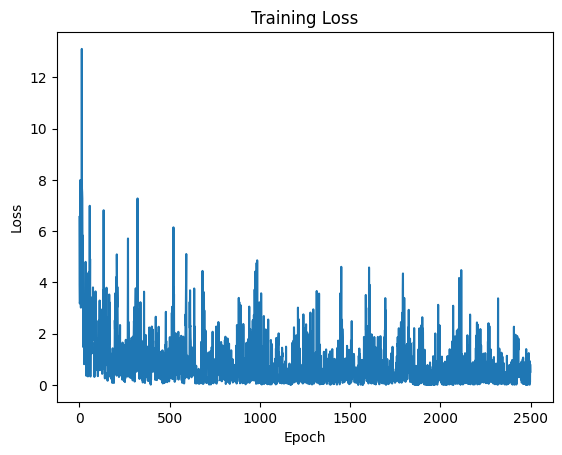

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
num_tests=500
rmse = test_model(model, sphere_mesh, renderer, cameras, lights, num_tests)
print(f"Root mean squared error over {num_tests} tests: {rmse:.2f} (degrees).")

Root mean squared error over 500 tests: 36.82 (degrees).


## Optimizing the colors and the weights simultaneously
The vertex colors were declared as a neural network parameter (nn.Parameter), so they will be learned during training.

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()
verts_min = verts.min(dim=0, keepdim=True)[0]
verts_max = verts.max(dim=0, keepdim=True)[0]
normalized_verts = (verts - verts_min) / (verts_max - verts_min)

vertex_colors = nn.Parameter(normalized_verts.unsqueeze(0))
textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [vertex_colors], 'lr': 0.001}
], lr=0.001)

criterion = nn.MSELoss()

Epoch [100/2500], Loss: 0.0343


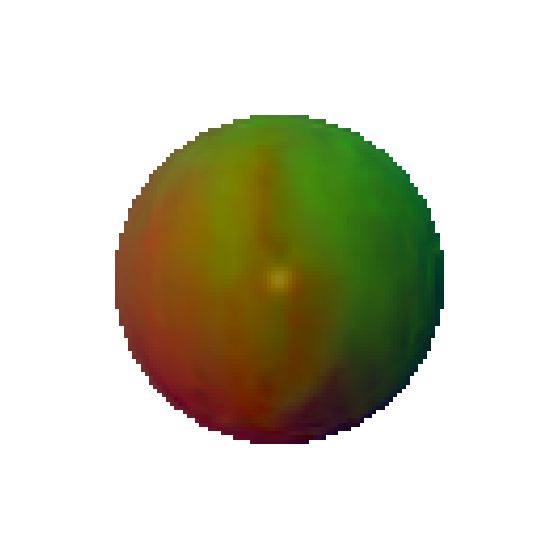

Epoch [200/2500], Loss: 0.0268


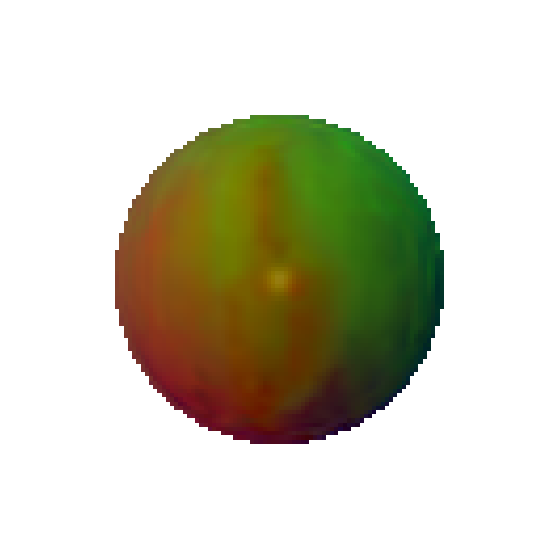

Epoch [300/2500], Loss: 0.0442


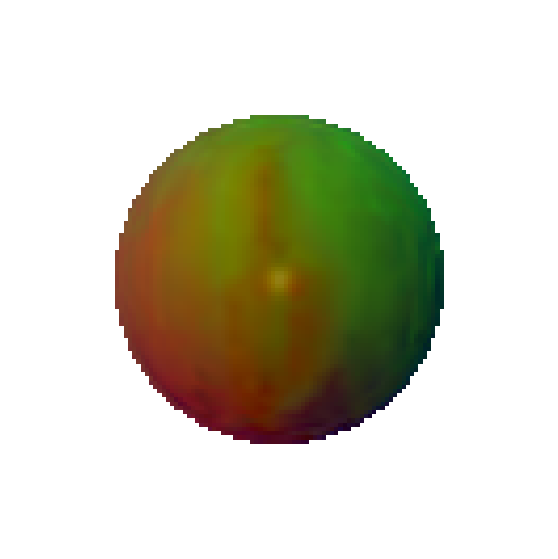

Epoch [400/2500], Loss: 0.1172


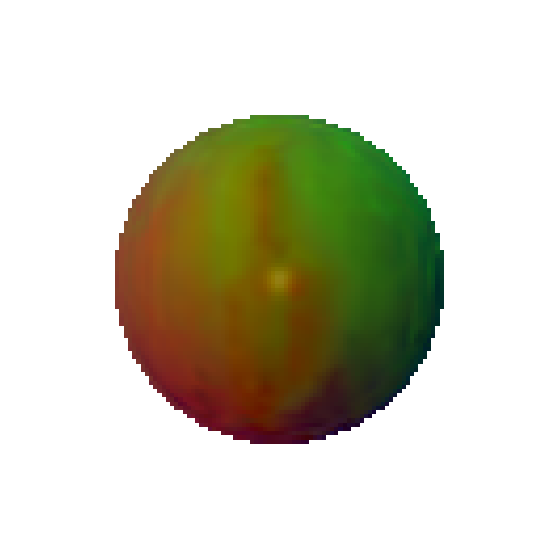

Epoch [500/2500], Loss: 0.0739


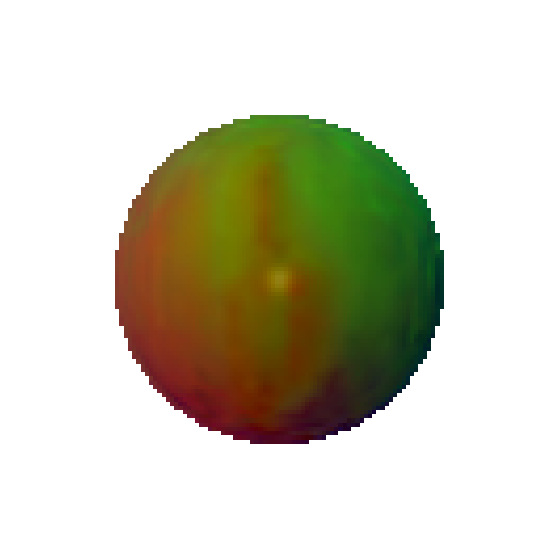

Epoch [600/2500], Loss: 0.0208


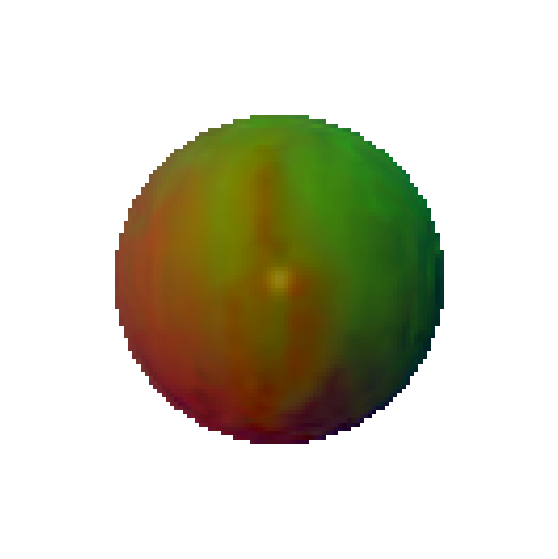

Epoch [700/2500], Loss: 0.1363


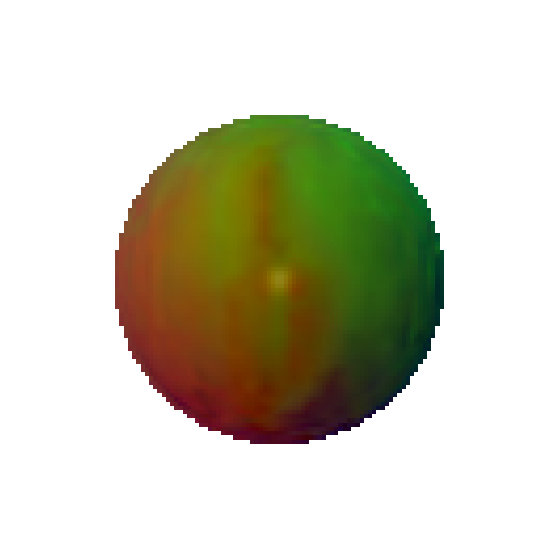

Epoch [800/2500], Loss: 0.3697


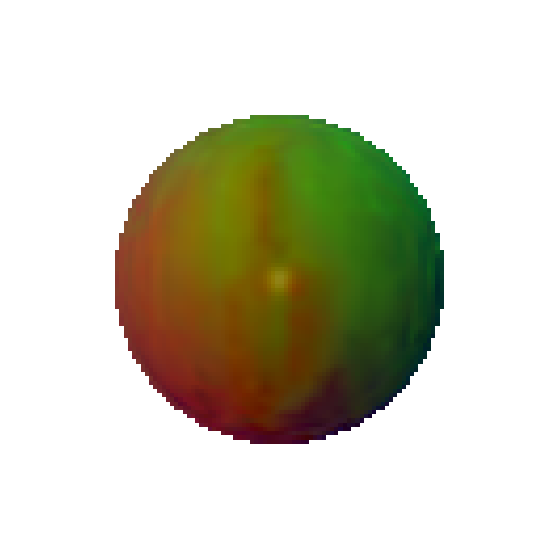

Epoch [900/2500], Loss: 0.1095


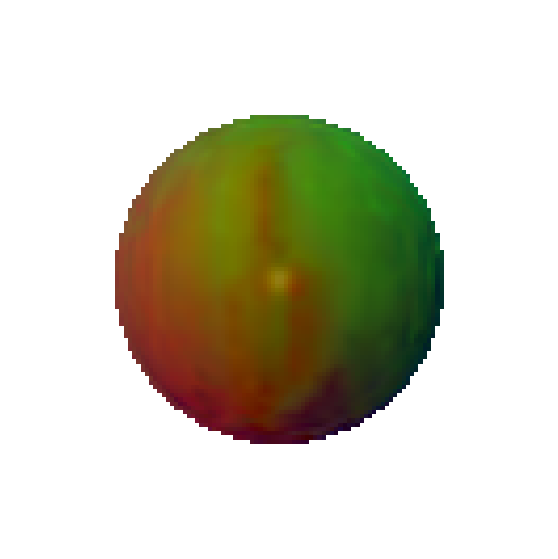

Epoch [1000/2500], Loss: 0.0071


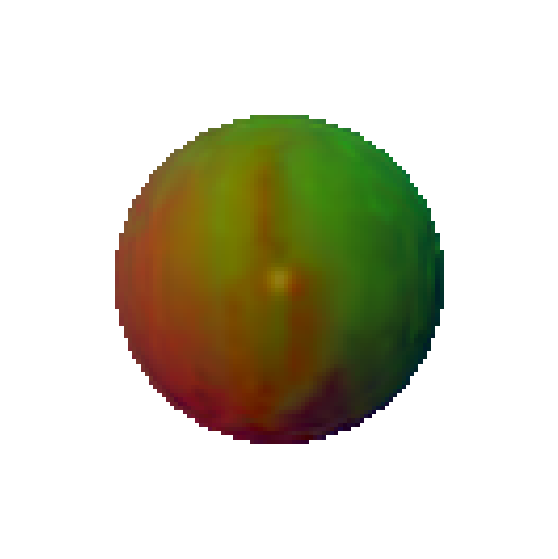

Epoch [1100/2500], Loss: 0.4888


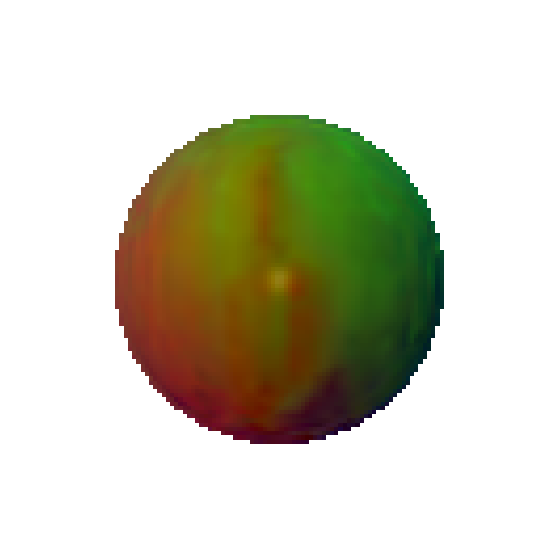

Epoch [1200/2500], Loss: 0.0057


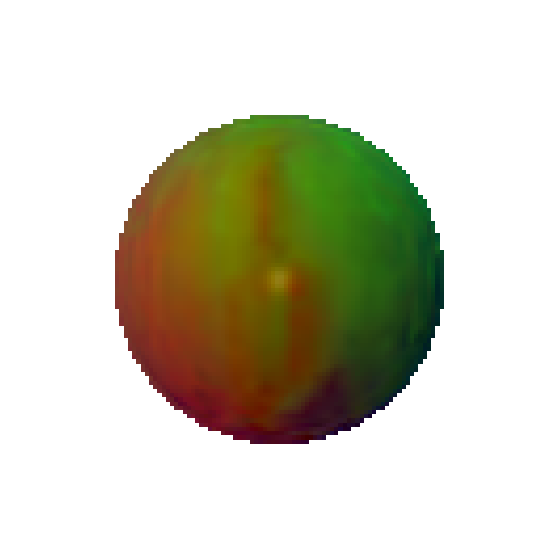

Epoch [1300/2500], Loss: 0.0853


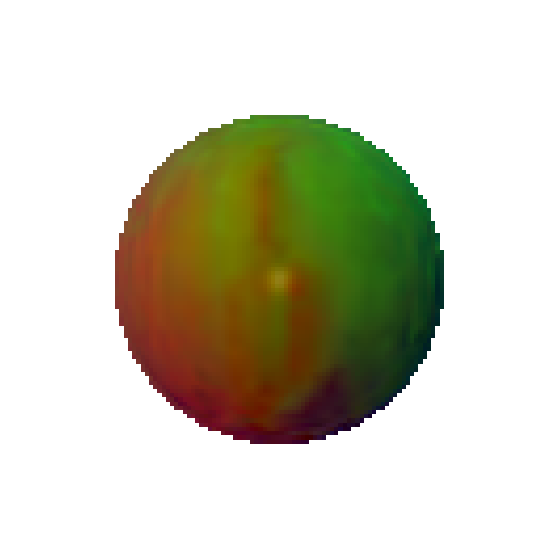

Epoch [1400/2500], Loss: 0.0034


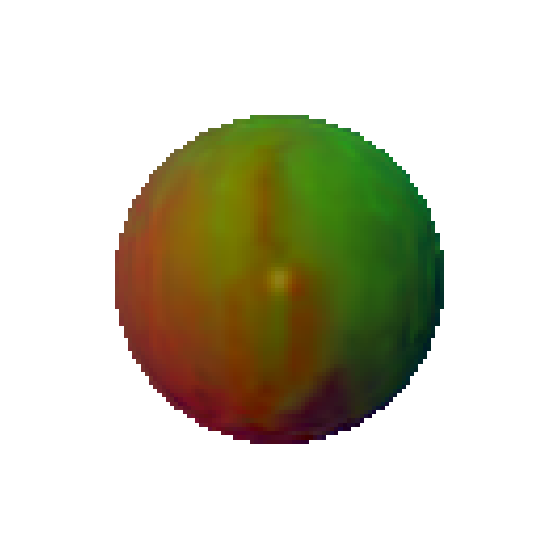

Epoch [1500/2500], Loss: 0.0147


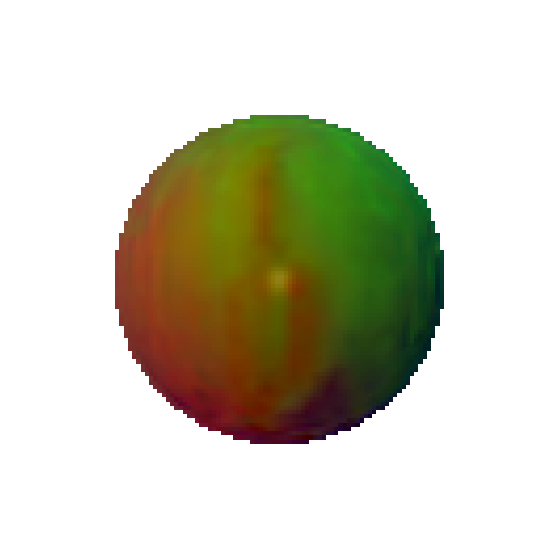

Epoch [1600/2500], Loss: 0.0179


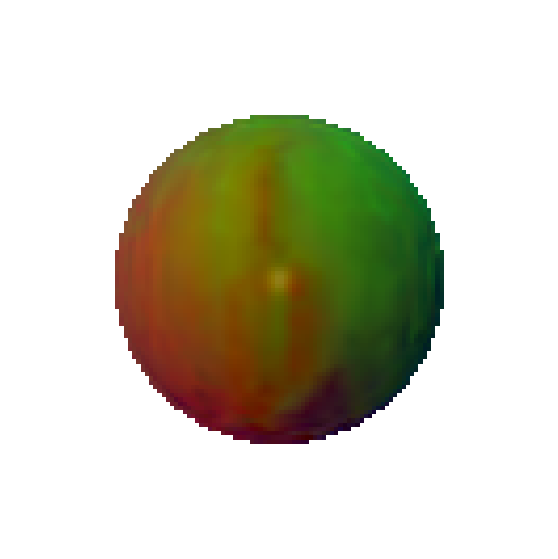

Epoch [1700/2500], Loss: 0.3585


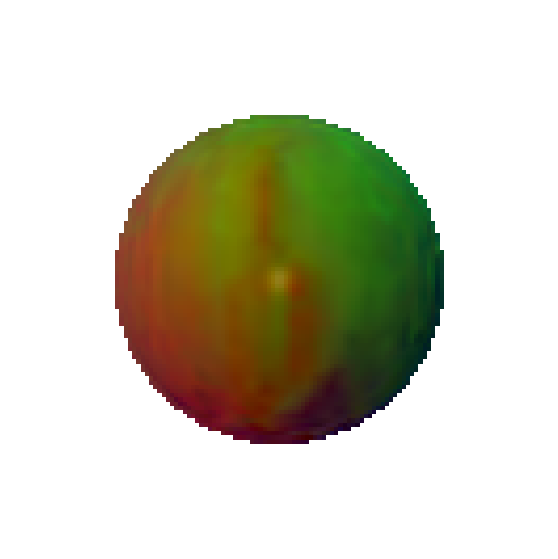

Epoch [1800/2500], Loss: 0.0063


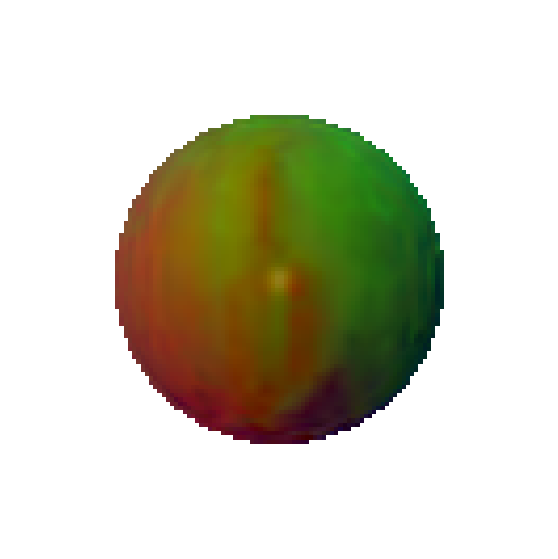

Epoch [1900/2500], Loss: 0.0204


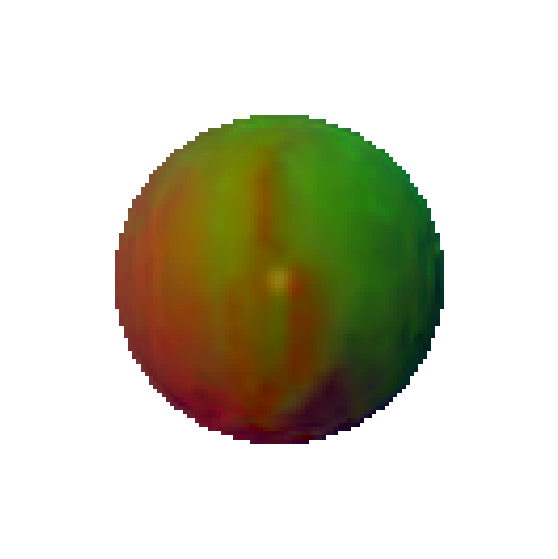

Epoch [2000/2500], Loss: 0.4143


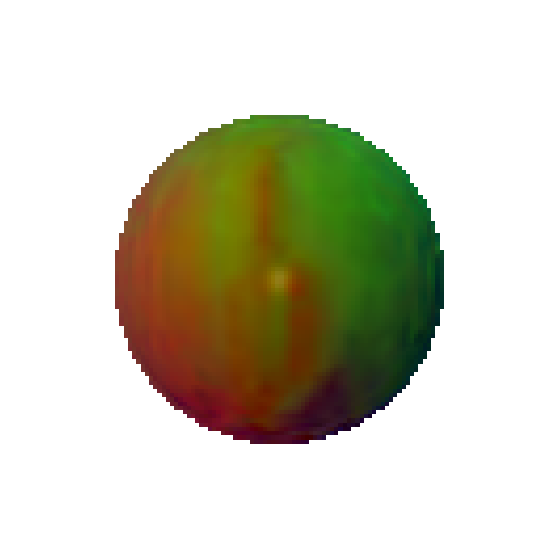

Epoch [2100/2500], Loss: 0.0069


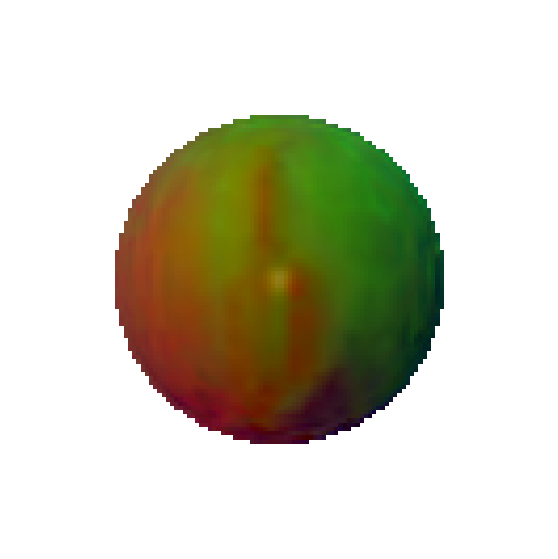

Epoch [2200/2500], Loss: 0.0018


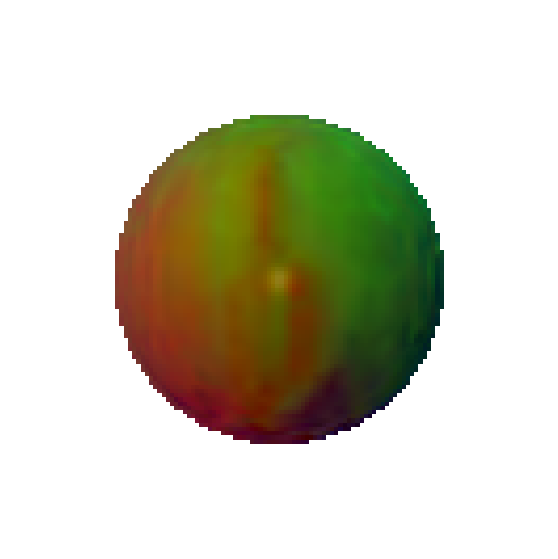

Epoch [2300/2500], Loss: 1.0304


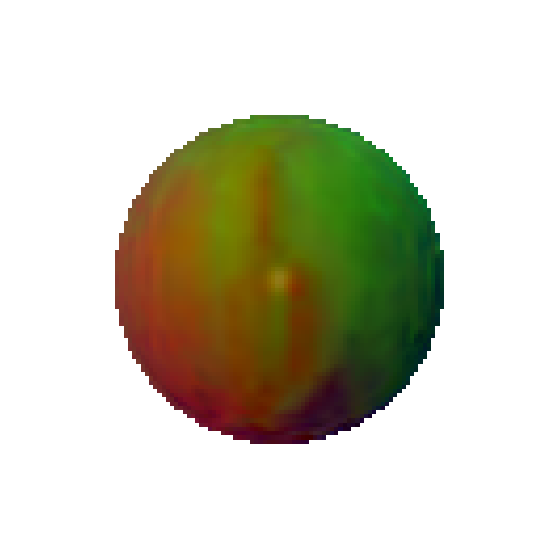

Epoch [2400/2500], Loss: 0.0659


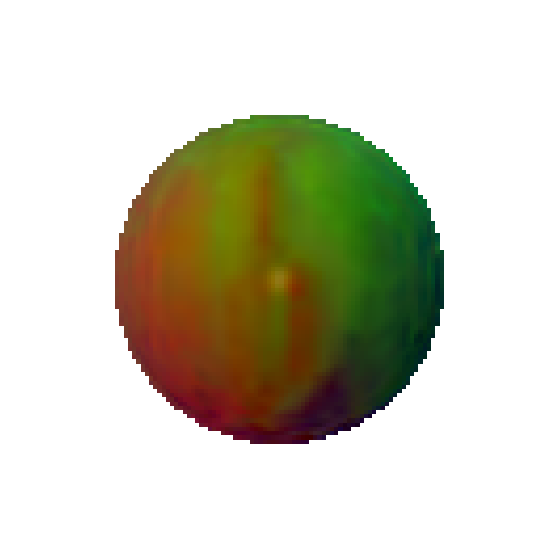

Epoch [2500/2500], Loss: 1.1126


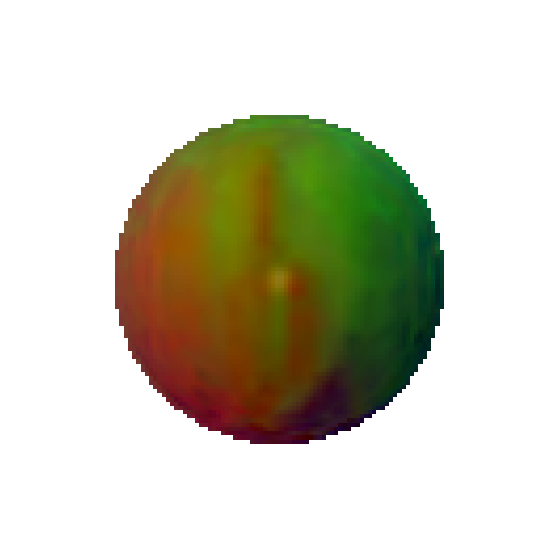

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, vertex_colors, renderer, cameras, lights, num_epochs=2500, batch_size=16)

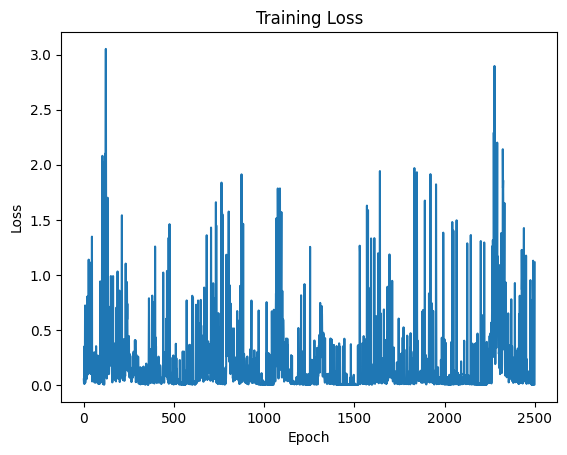

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
num_tests=500
rmse = test_model(model, sphere_mesh, renderer, cameras, lights, num_tests=500)
print(f"Root mean squared error over {num_tests} tests: {rmse:.2f} (degrees).")

Root mean squared error over 500 tests: 25.90 (degrees).


# Experiments - color optimization (monochrome initial color)

## Optimizing only the weights

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.expand(verts.shape)
vertex_colors = nn.Parameter(vertex_colors.unsqueeze(0))

textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

optimizer = optim.Adam([
    {'params': model.parameters()}
], lr=0.001)

criterion = nn.MSELoss()

Epoch [100/2500], Loss: 2.5789


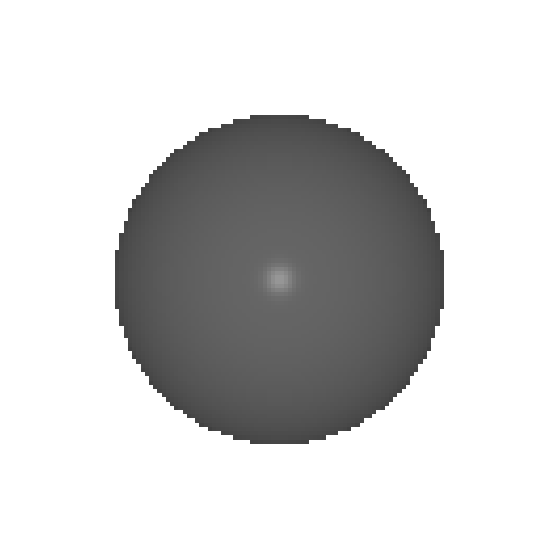

Epoch [200/2500], Loss: 3.0294


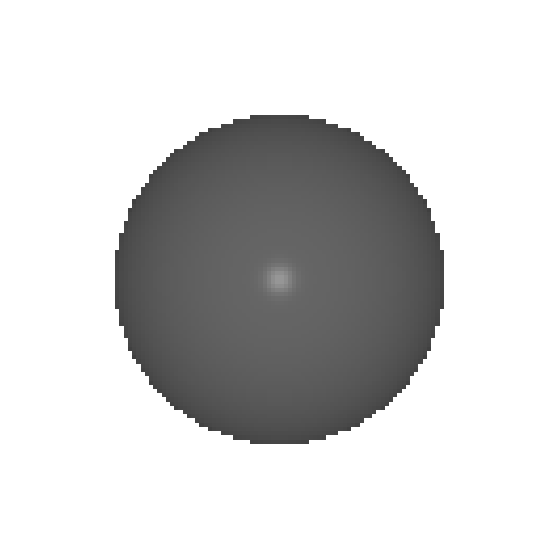

Epoch [300/2500], Loss: 2.1705


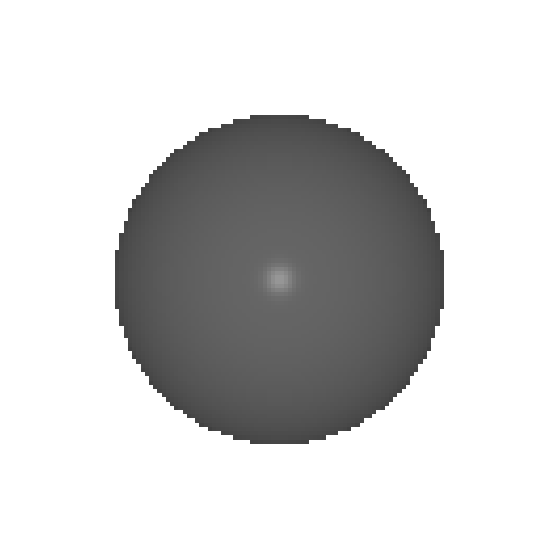

Epoch [400/2500], Loss: 3.4266


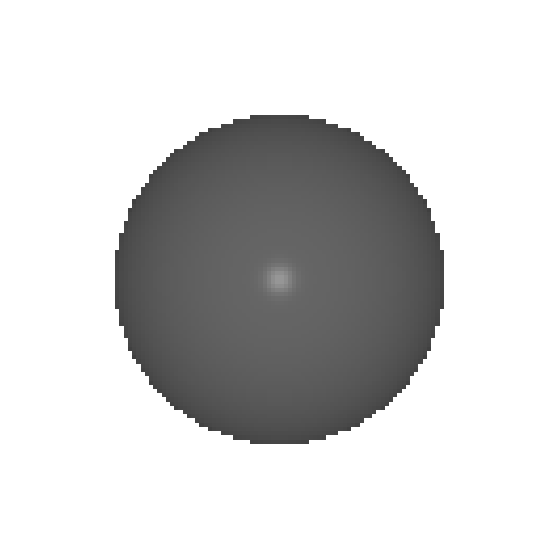

Epoch [500/2500], Loss: 5.5335


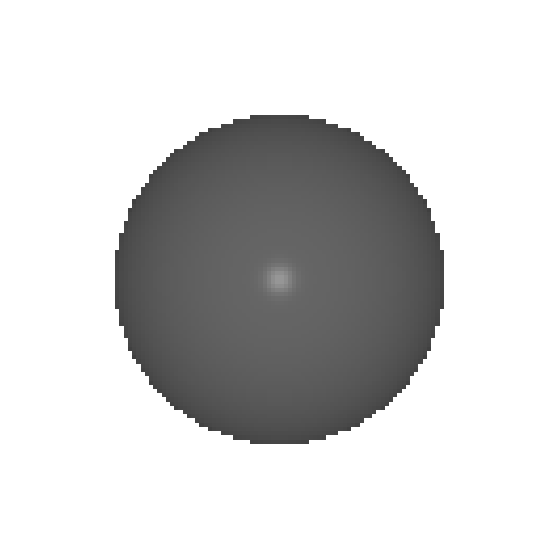

Epoch [600/2500], Loss: 4.0163


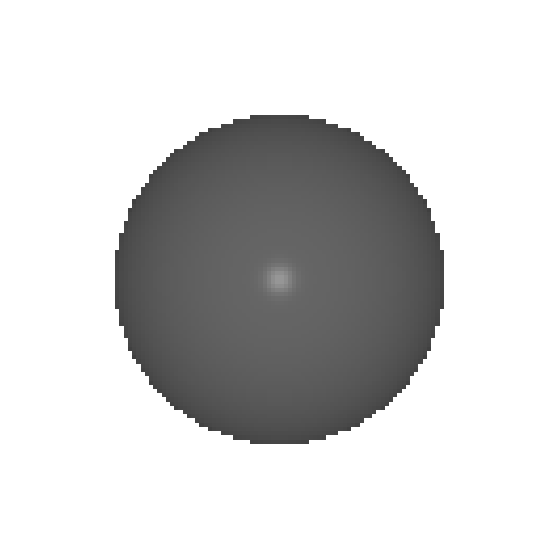

Epoch [700/2500], Loss: 3.6106


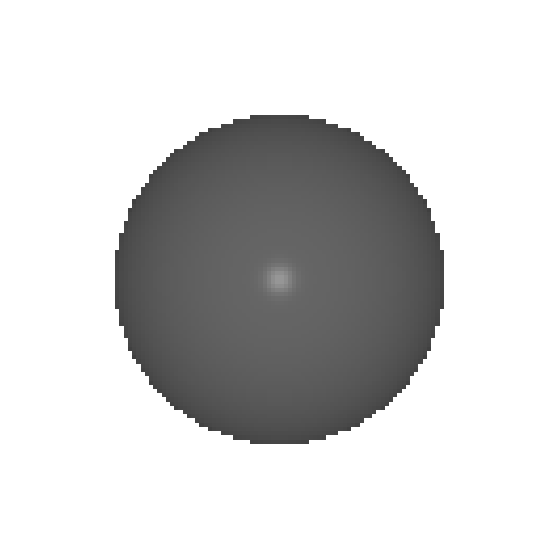

Epoch [800/2500], Loss: 3.6307


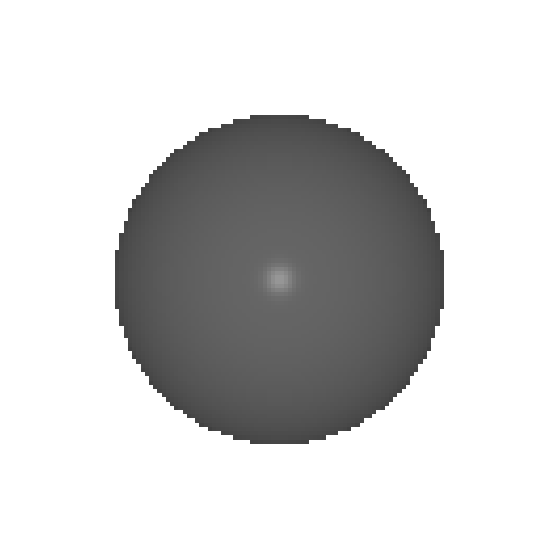

Epoch [900/2500], Loss: 4.6152


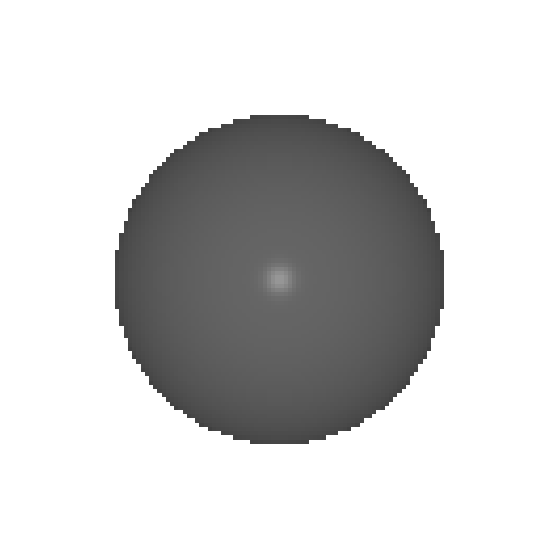

Epoch [1000/2500], Loss: 2.7788


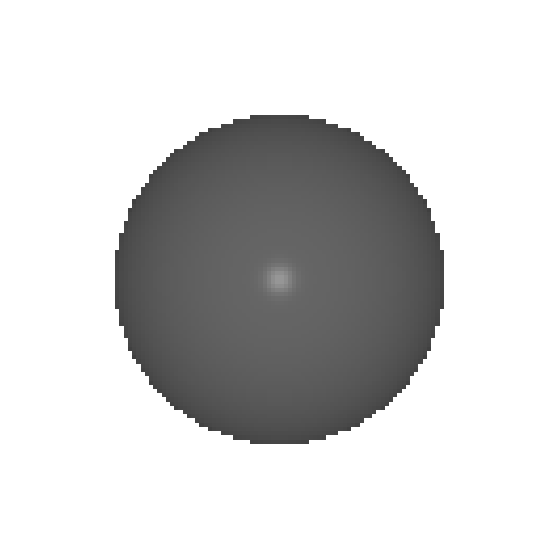

Epoch [1100/2500], Loss: 4.1261


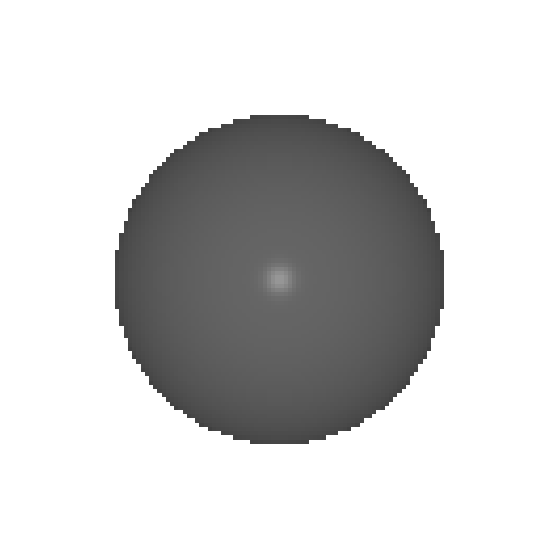

Epoch [1200/2500], Loss: 3.4874


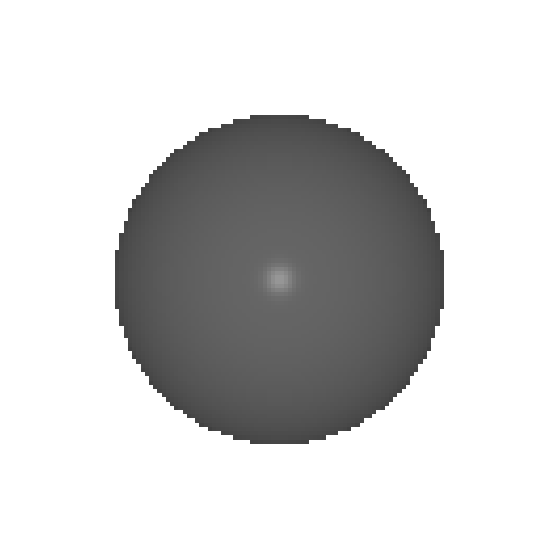

Epoch [1300/2500], Loss: 3.6496


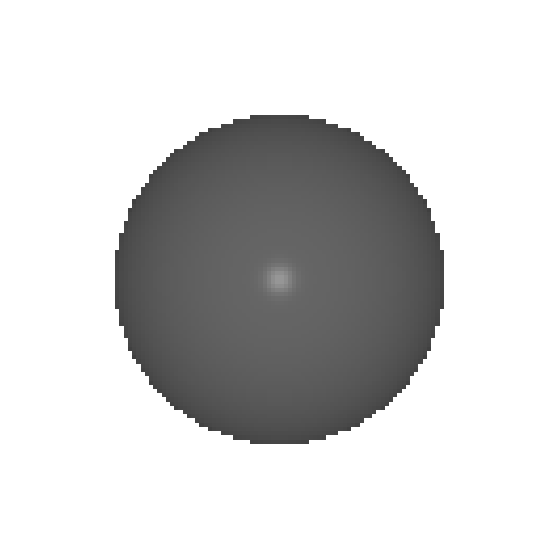

Epoch [1400/2500], Loss: 4.1515


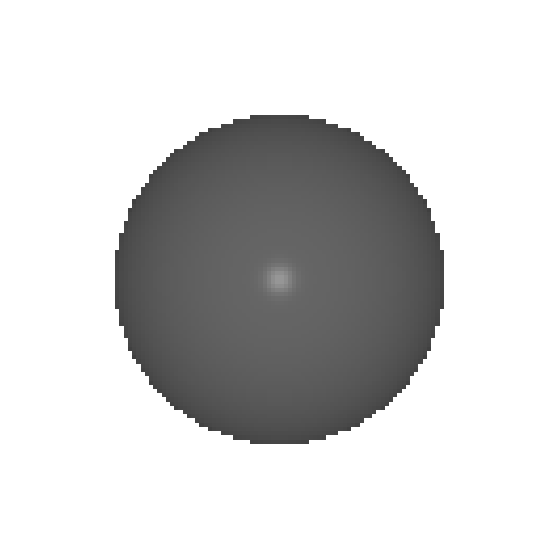

Epoch [1500/2500], Loss: 3.4071


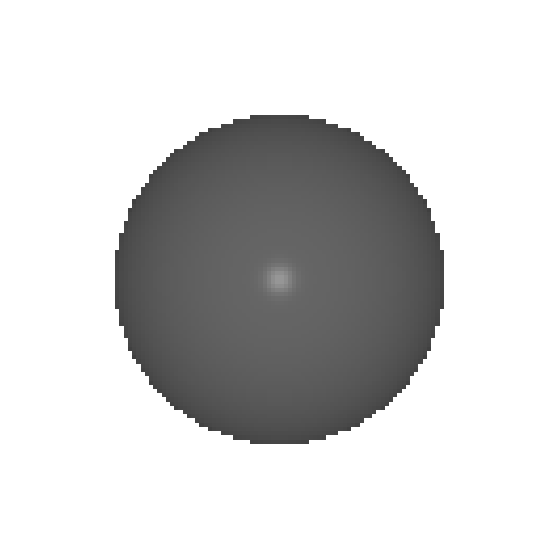

Epoch [1600/2500], Loss: 3.3160


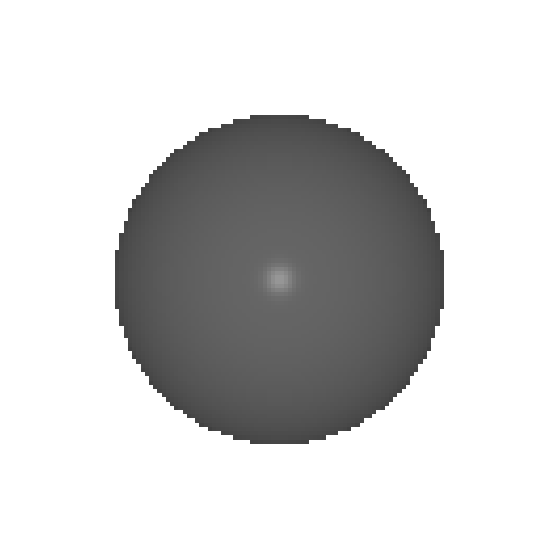

Epoch [1700/2500], Loss: 3.0344


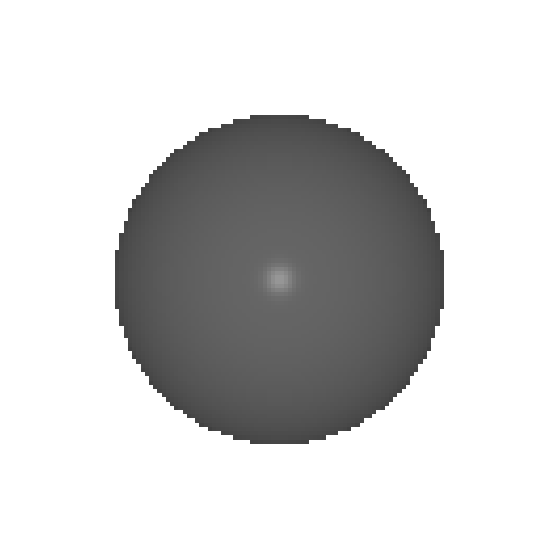

Epoch [1800/2500], Loss: 4.4112


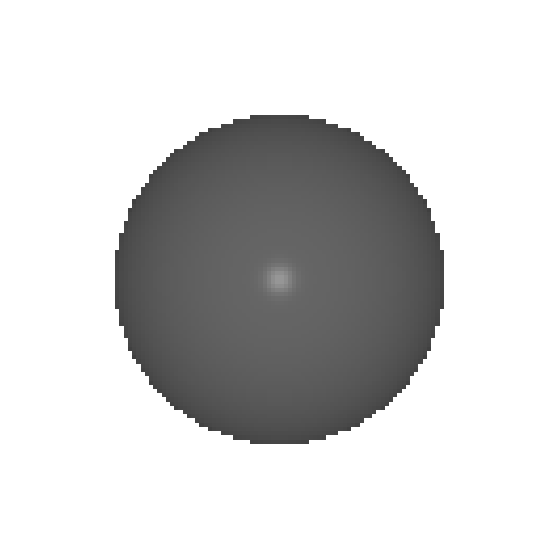

Epoch [1900/2500], Loss: 3.1233


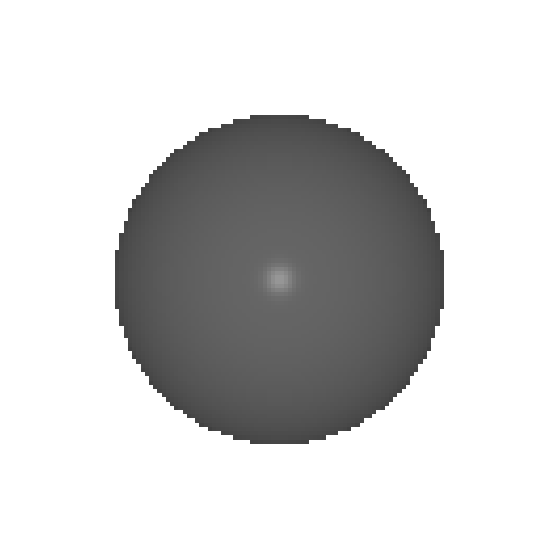

Epoch [2000/2500], Loss: 3.6029


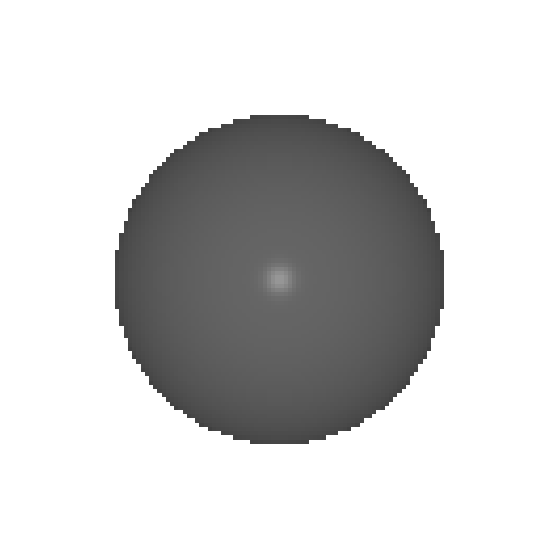

Epoch [2100/2500], Loss: 2.9563


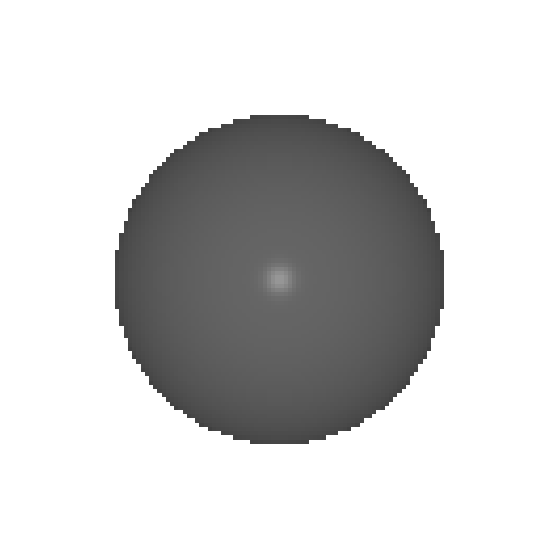

Epoch [2200/2500], Loss: 2.6688


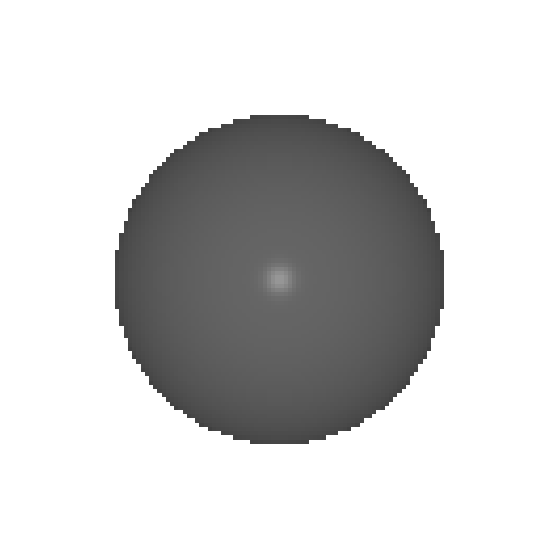

Epoch [2300/2500], Loss: 2.8924


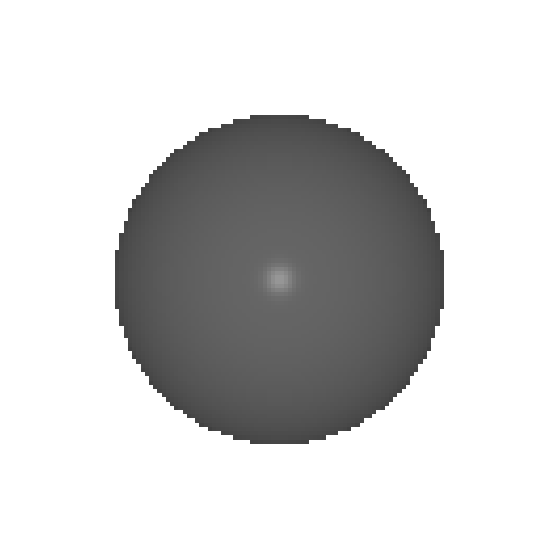

Epoch [2400/2500], Loss: 2.4103


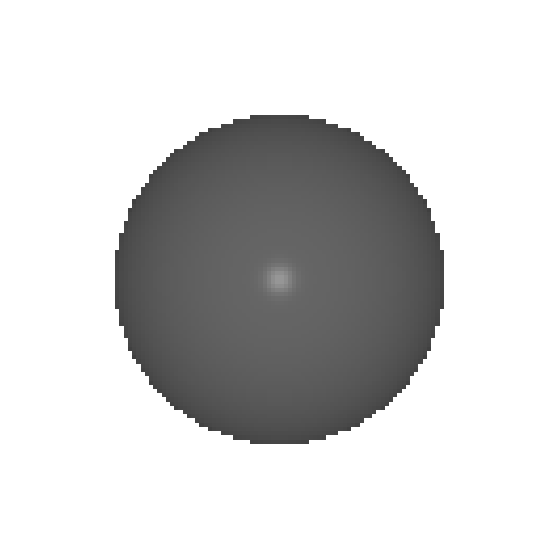

Epoch [2500/2500], Loss: 3.8009


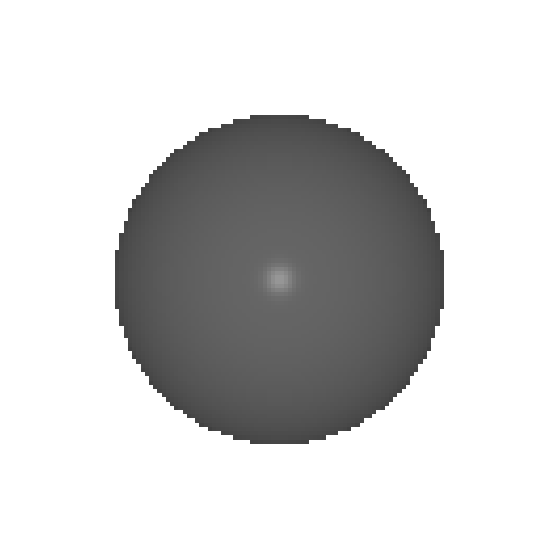

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, vertex_colors, renderer, cameras, lights, num_epochs=2500, batch_size=16)

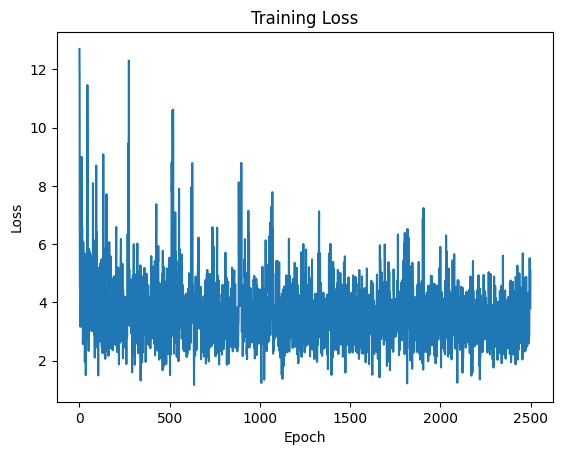

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
num_tests=500
rmse = test_model(model, sphere_mesh, renderer, cameras, lights, num_tests)
print(f"Root mean squared error over {num_tests} tests: {rmse:.2f} (degrees).")

Root mean squared error over 500 tests: 108.81 (degrees).


## Optimizing the colors and the weights simultaneously
The vertex colors were declared as a neural network parameter (nn.Parameter), so they will be learned during training.

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.repeat(verts.shape[0], 1)
vertex_colors = nn.Parameter(vertex_colors.unsqueeze(0))

textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [vertex_colors], 'lr': 0.001}
], lr=0.001)

criterion = nn.MSELoss()

Epoch [100/2500], Loss: 8.5839


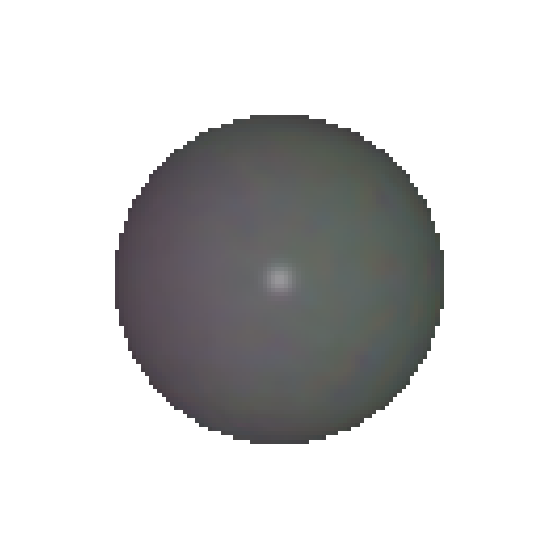

Epoch [200/2500], Loss: 2.7202


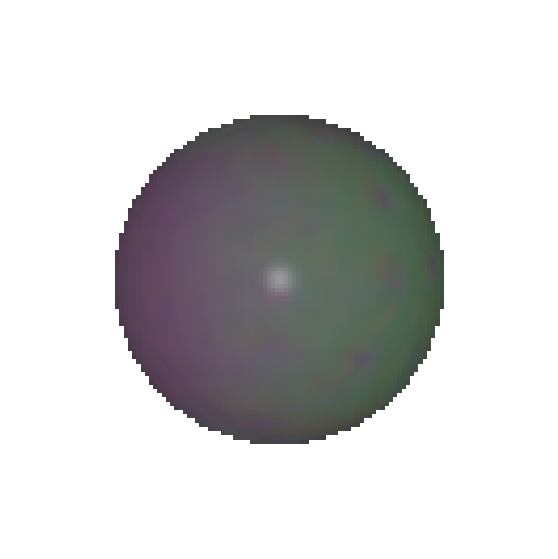

Epoch [300/2500], Loss: 2.5190


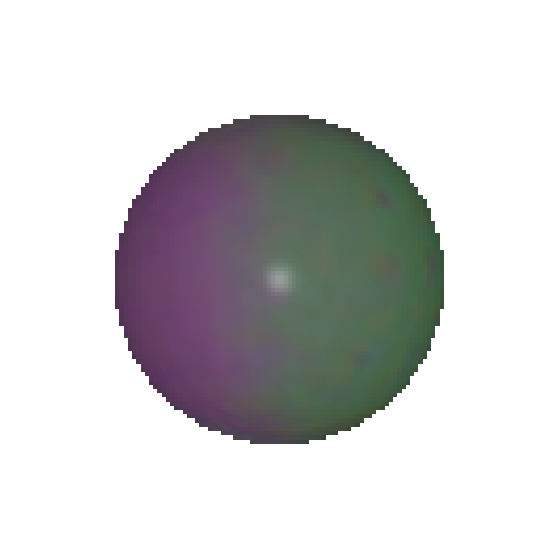

Epoch [400/2500], Loss: 0.5129


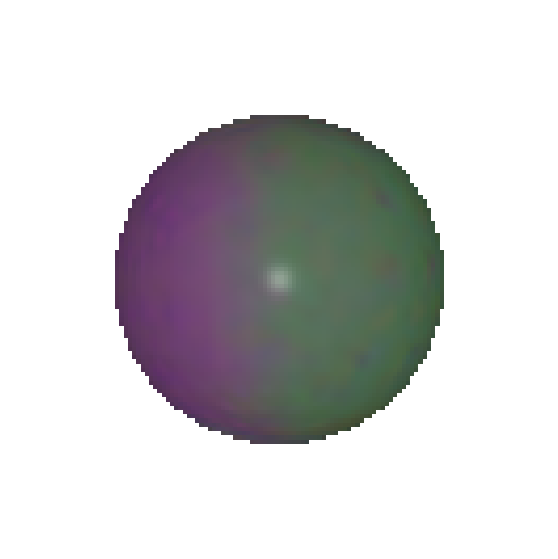

Epoch [500/2500], Loss: 2.2005


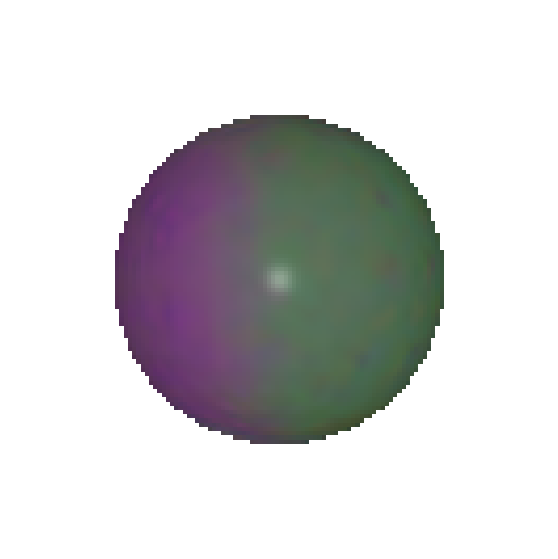

Epoch [600/2500], Loss: 0.1233


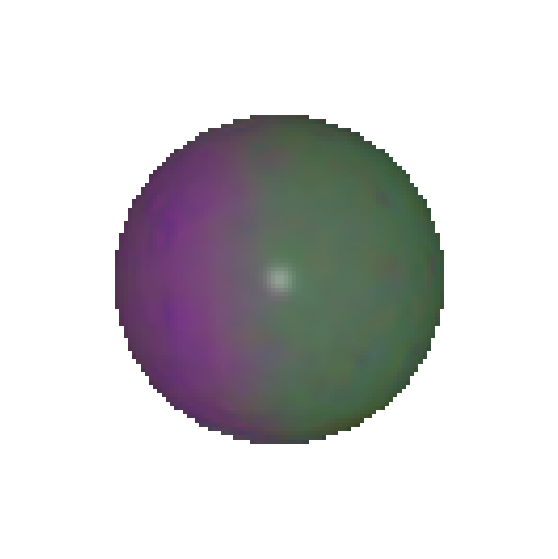

Epoch [700/2500], Loss: 0.0386


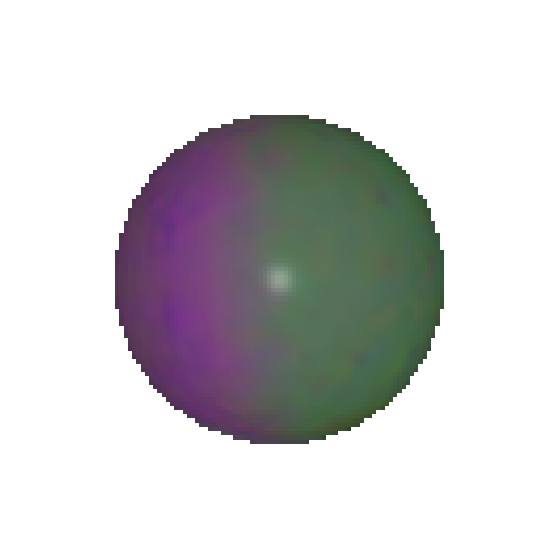

Epoch [800/2500], Loss: 1.8106


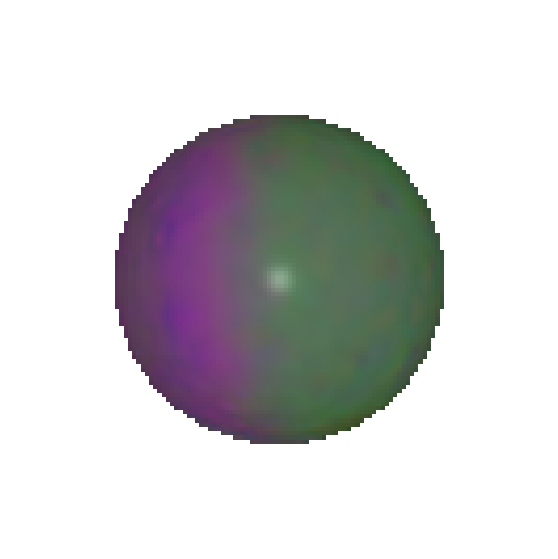

Epoch [900/2500], Loss: 1.7715


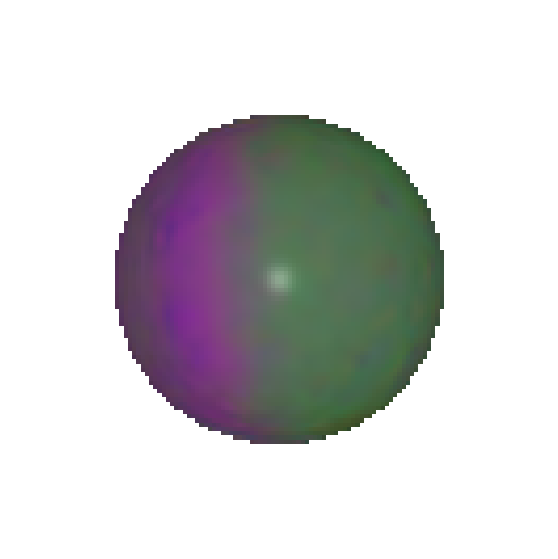

Epoch [1000/2500], Loss: 0.0662


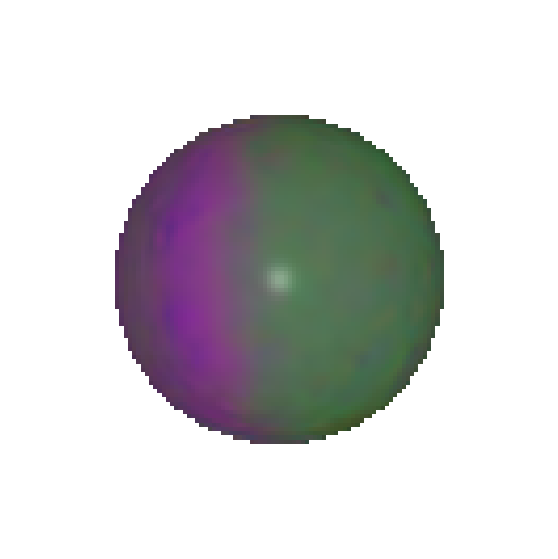

Epoch [1100/2500], Loss: 1.6093


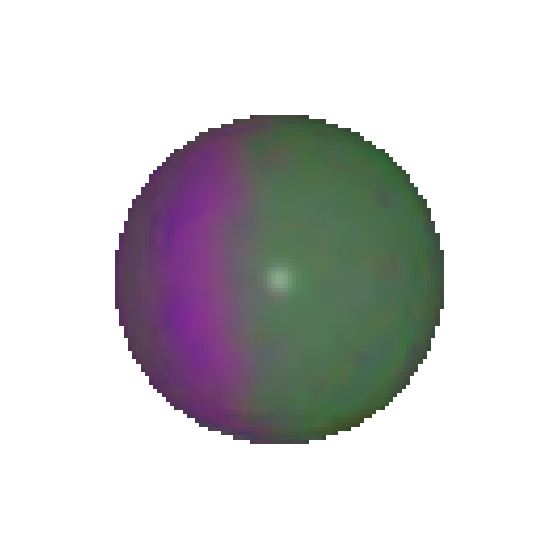

Epoch [1200/2500], Loss: 0.0152


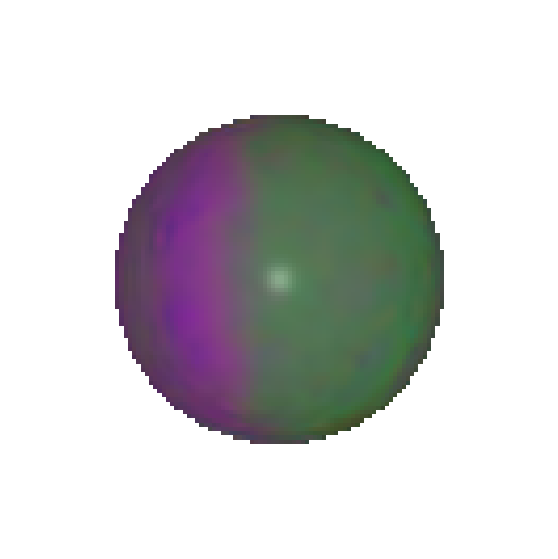

Epoch [1300/2500], Loss: 0.0105


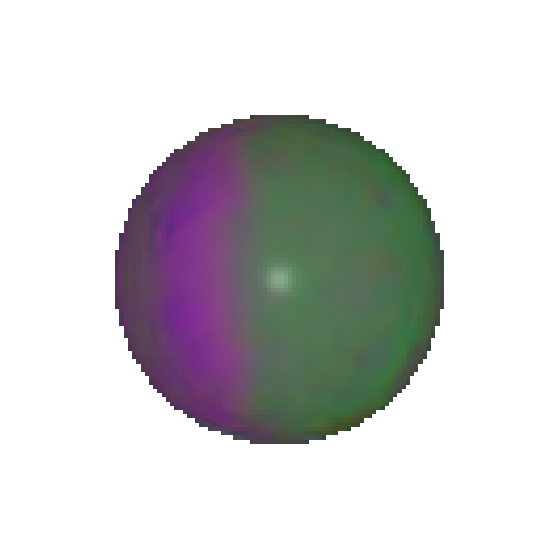

Epoch [1400/2500], Loss: 0.0401


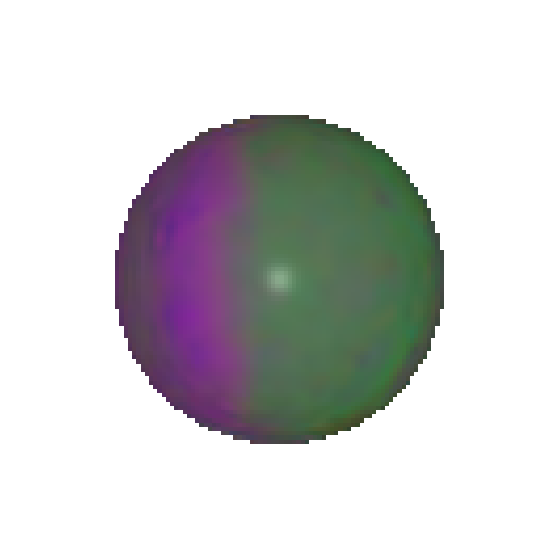

Epoch [1500/2500], Loss: 0.0099


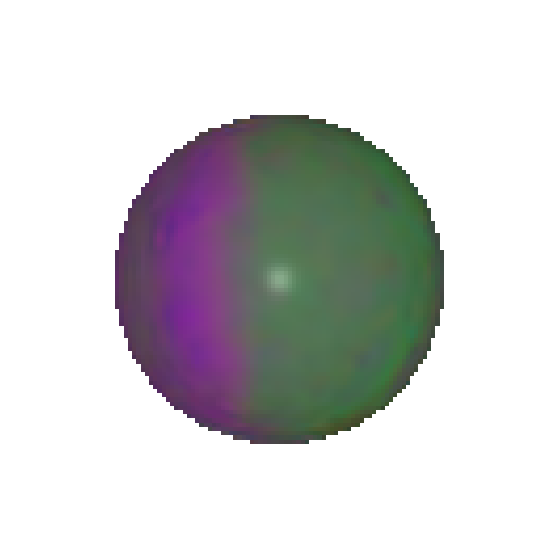

Epoch [1600/2500], Loss: 0.0453


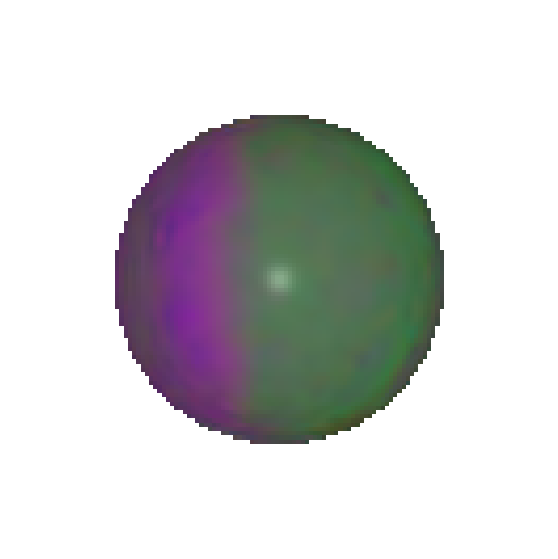

Epoch [1700/2500], Loss: 0.1621


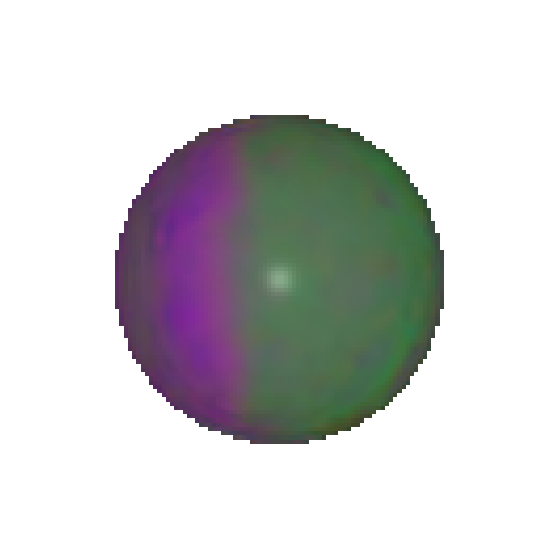

Epoch [1800/2500], Loss: 0.0809


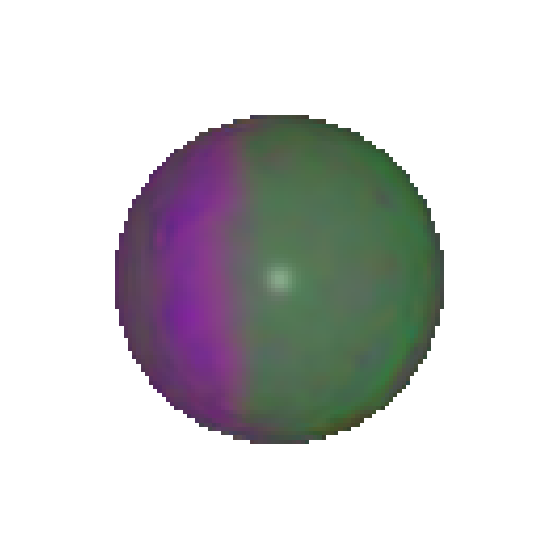

Epoch [1900/2500], Loss: 0.2820


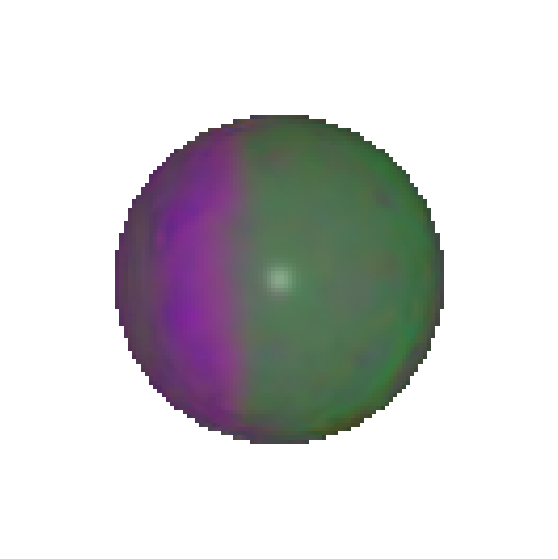

Epoch [2000/2500], Loss: 0.0880


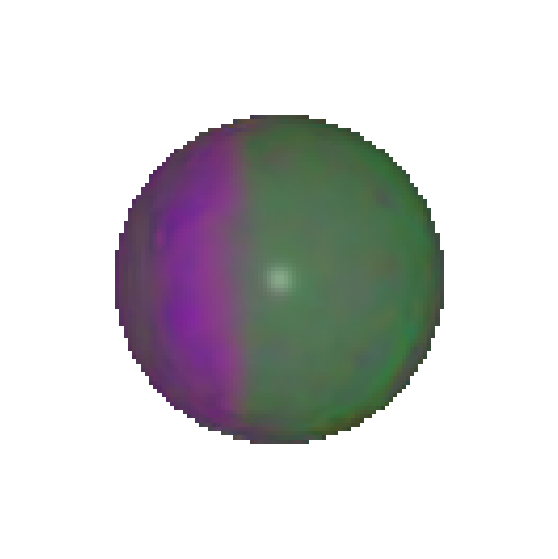

Epoch [2100/2500], Loss: 0.1141


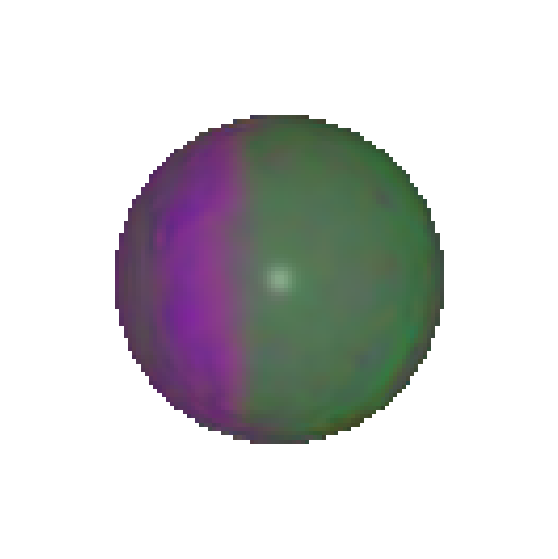

Epoch [2200/2500], Loss: 0.0377


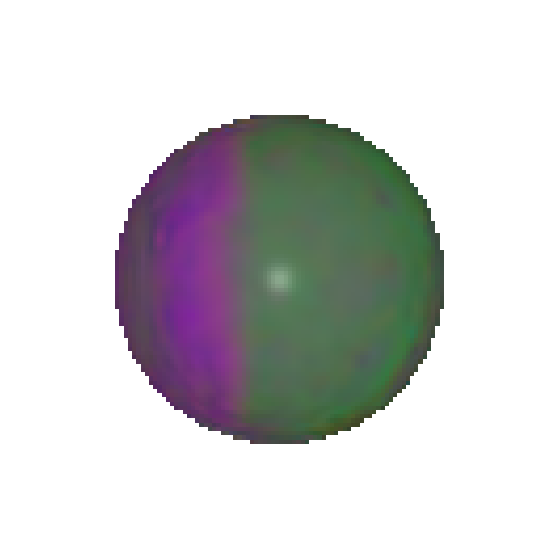

Epoch [2300/2500], Loss: 0.0602


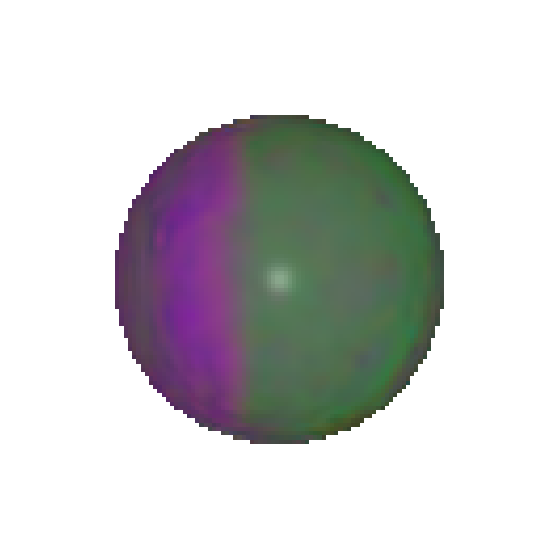

Epoch [2400/2500], Loss: 0.0203


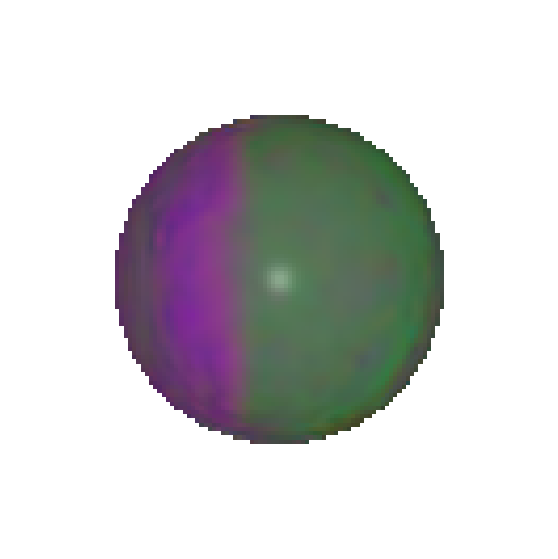

Epoch [2500/2500], Loss: 0.0138


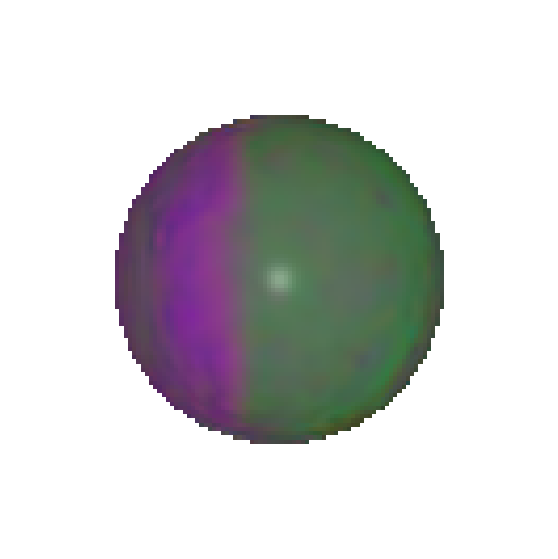

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, vertex_colors, renderer, cameras, lights, num_epochs=2500, batch_size=16)

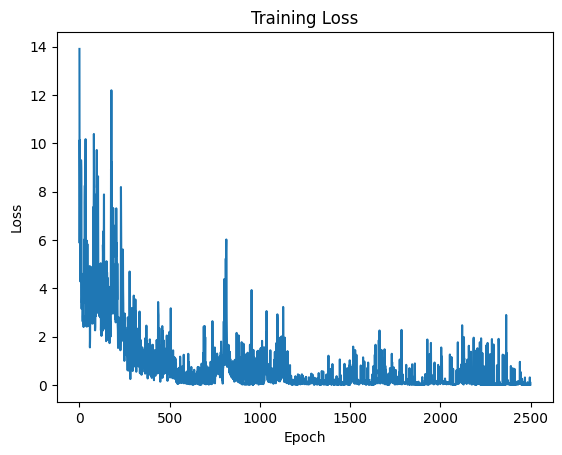

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
num_tests=500
rmse = test_model(model, sphere_mesh, renderer, cameras, lights, num_tests=500)
print(f"Root mean squared error over {num_tests} tests: {rmse:.2f} (degrees).")

Root mean squared error over 500 tests: 13.67 (degrees).


# Experiments - shape optimization

In [ ]:
def train_model(model, optimizer, mesh, deform_verts, renderer, cameras, lights, num_epochs=500, batch_size=32, lr=0.001, criterion=nn.MSELoss(), use_smoothing_loss=False):
  losses = []
  for epoch in range(num_epochs):
    total_loss = 0

    for i in range(batch_size):
      optimizer.zero_grad()

      deformed_mesh = mesh.clone().offset_verts(deform_verts)

      angle = np.random.randint(0, 360)
      rotated_sphere = create_rotated_sphere(deformed_mesh, angle, device)

      image = renderer(rotated_sphere, cameras=cameras, lights=lights)
      image = image[..., :3].contiguous().permute(0, 3, 1, 2)

      predicted_angle = model(image)
      target_angle = torch.tensor([[angle * np.pi / 180.0]], device=device)

      loss = criterion(predicted_angle, target_angle)
      if use_smoothing_loss:
          loss += mesh_laplacian_smoothing(deformed_mesh, method="uniform")  # Add weight to the smoothing loss? How much?

      loss.backward()

      total_loss += loss.item()

    avg_epoch_loss = total_loss / batch_size
    losses.append(avg_epoch_loss)
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
        deformed_mesh = mesh.clone().offset_verts(deform_verts)
        visualize_sphere(deformed_mesh, vertex_colors, renderer, cameras, lights)

  return losses

## Optimizing the shape and the weights simultaneously

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.repeat(verts.shape[0], 1)
vertex_colors = vertex_colors.unsqueeze(0)

textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)  # Preuzeto s https://pytorch3d.org/tutorials/deform_source_mesh_to_target_mesh

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [deform_verts], 'lr': 0.001}
], lr=0.001)

criterion = nn.MSELoss()

Epoch [100/2500], Loss: 9.7208


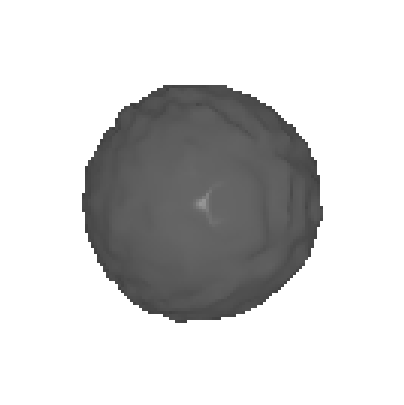

Epoch [200/2500], Loss: 5.9626


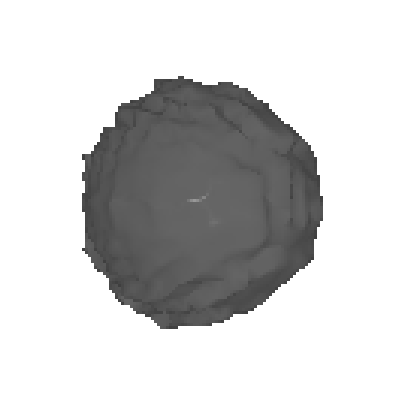

Epoch [300/2500], Loss: 3.4512


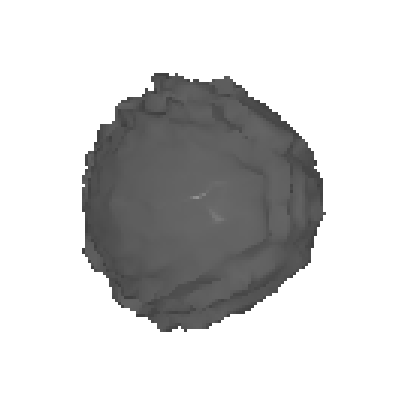

Epoch [400/2500], Loss: 2.8837


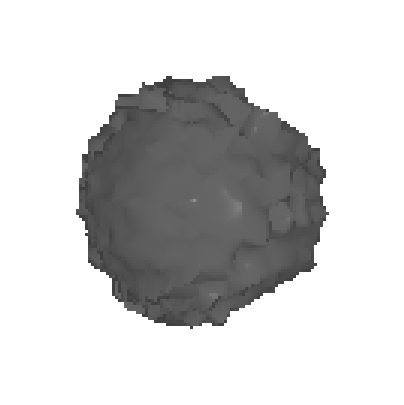

Epoch [500/2500], Loss: 1.8504


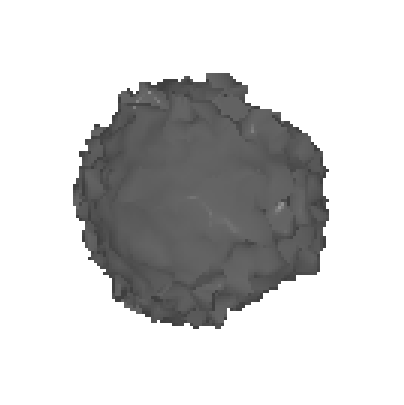

Epoch [600/2500], Loss: 0.1722


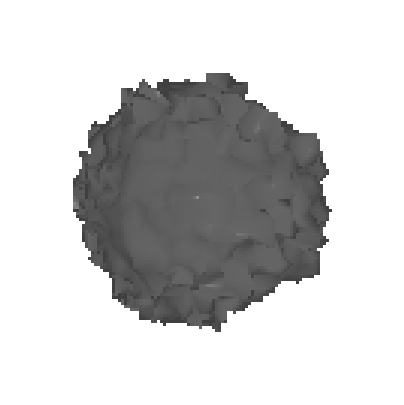

Epoch [700/2500], Loss: 0.4079


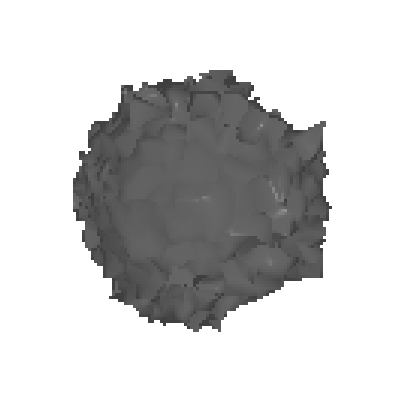

Epoch [800/2500], Loss: 1.1340


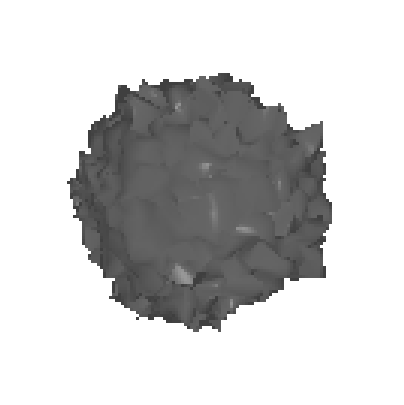

Epoch [900/2500], Loss: 0.3832


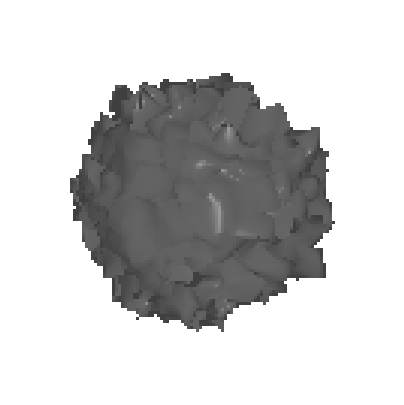

Epoch [1000/2500], Loss: 0.2865


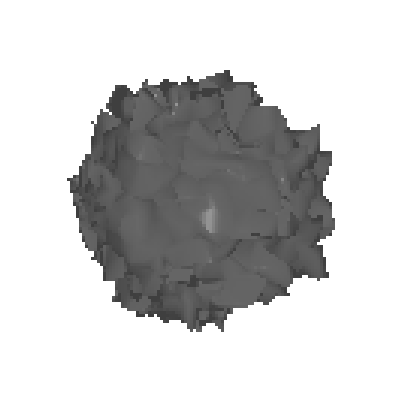

Epoch [1100/2500], Loss: 0.4370


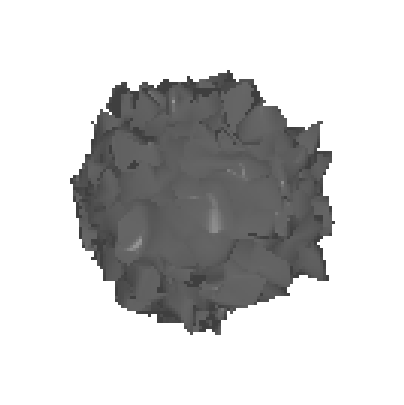

Epoch [1200/2500], Loss: 0.1133


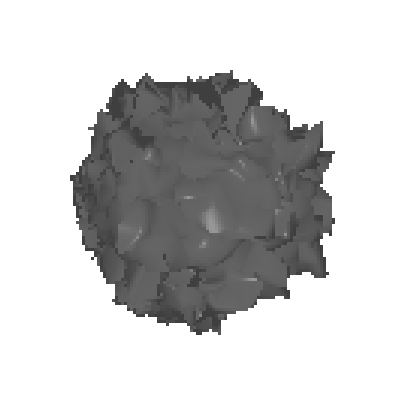

Epoch [1300/2500], Loss: 0.0840


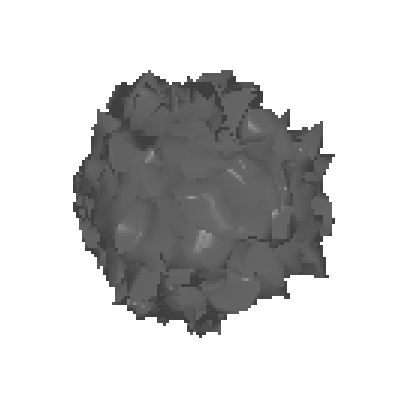

Epoch [1400/2500], Loss: 0.3310


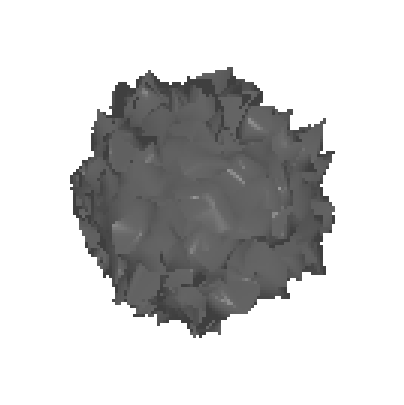

Epoch [1500/2500], Loss: 0.2264


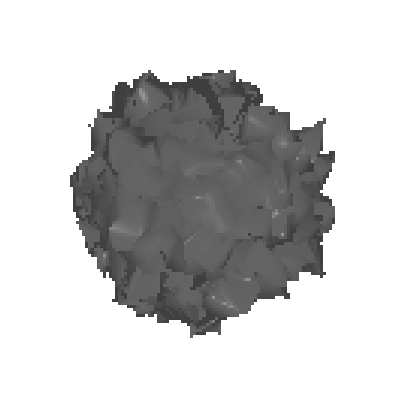

Epoch [1600/2500], Loss: 1.7376


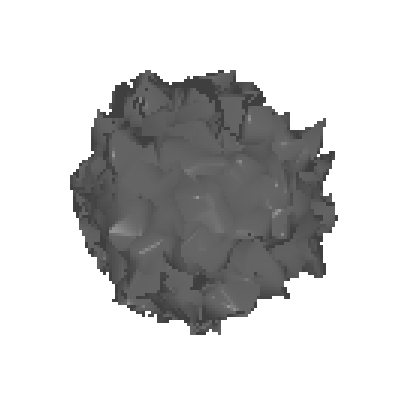

Epoch [1700/2500], Loss: 0.8963


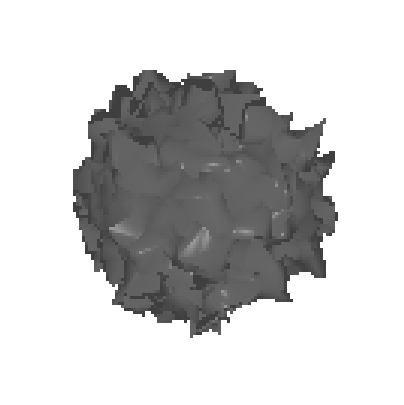

Epoch [1800/2500], Loss: 0.1435


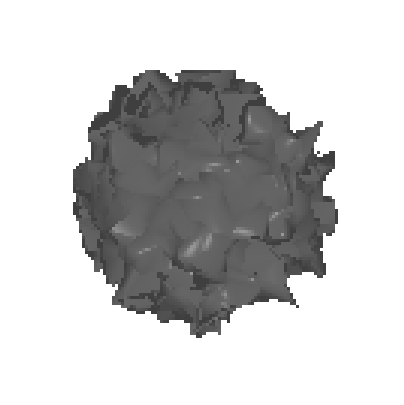

Epoch [1900/2500], Loss: 0.4824


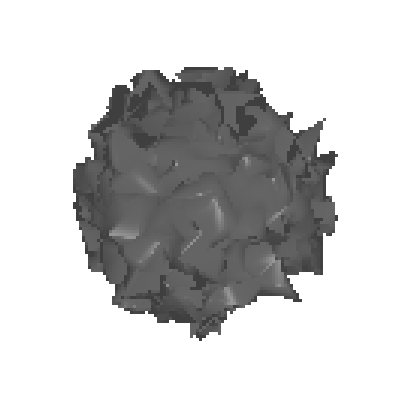

Epoch [2000/2500], Loss: 0.1380


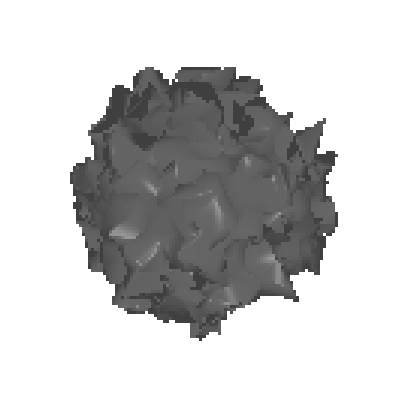

Epoch [2100/2500], Loss: 0.0658


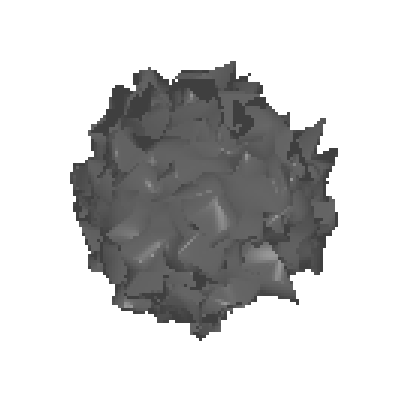

Epoch [2200/2500], Loss: 1.0541


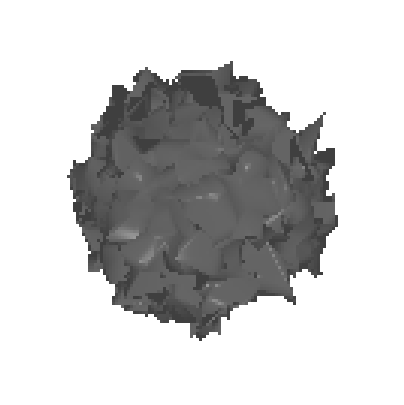

Epoch [2300/2500], Loss: 0.2383


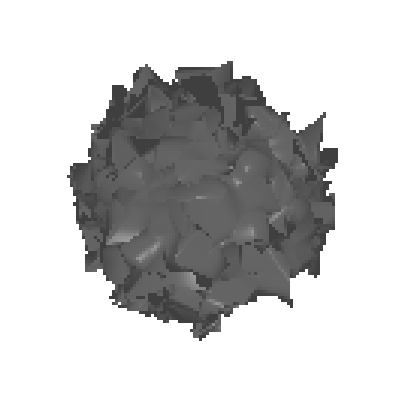

Epoch [2400/2500], Loss: 0.0863


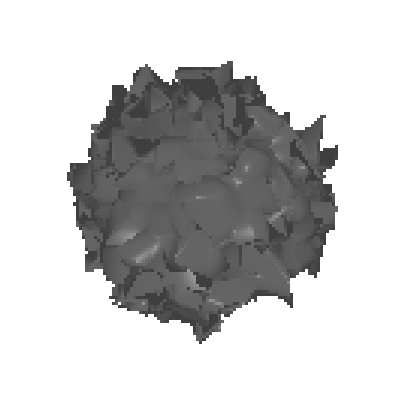

Epoch [2500/2500], Loss: 0.1608


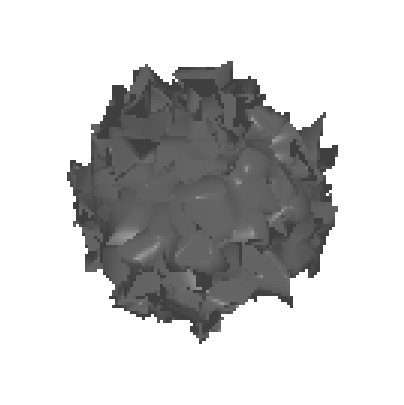

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, deform_verts, renderer, cameras, lights, num_epochs=2500, batch_size=16)

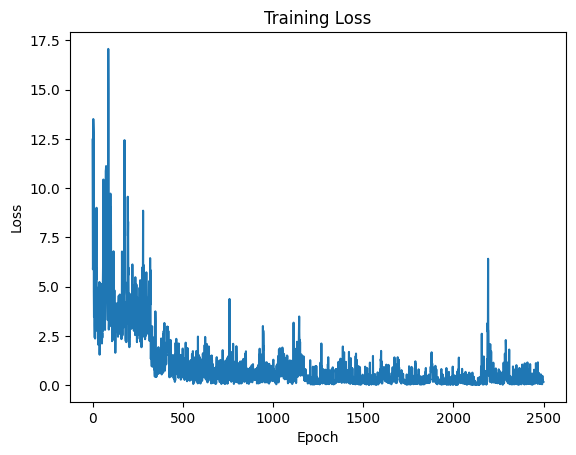

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
deformed_sphere_mesh = sphere_mesh.clone().offset_verts(deform_verts)

In [ ]:
num_tests=500
rmse = test_model(model, deformed_sphere_mesh, renderer, cameras, lights, num_tests=500)
print(f"Root mean squared error over {num_tests} tests: {rmse:.2f} (degrees).")

Root mean squared error over 500 tests: 34.90 (degrees).


## Optimizing the shape and the weights simultaneously with smoothing

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.repeat(verts.shape[0], 1)
vertex_colors = vertex_colors.unsqueeze(0)

textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)  # Preuzeto s https://pytorch3d.org/tutorials/deform_source_mesh_to_target_mesh

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [deform_verts], 'lr': 0.001}
], lr=0.001)

criterion = nn.MSELoss()

Epoch [100/2500], Loss: 3.9948


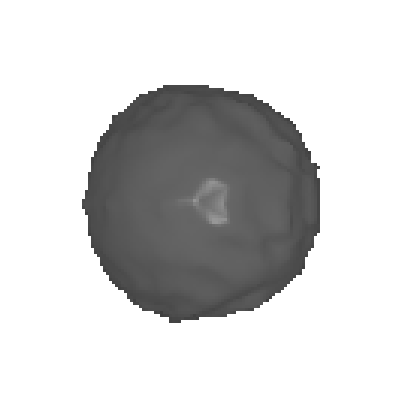

Epoch [200/2500], Loss: 4.2697


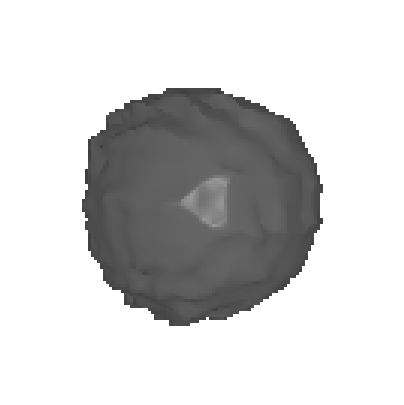

Epoch [300/2500], Loss: 1.8904


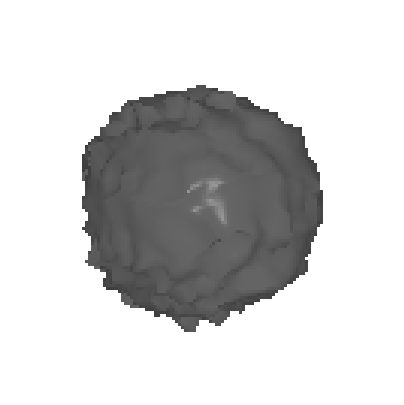

Epoch [400/2500], Loss: 1.4203


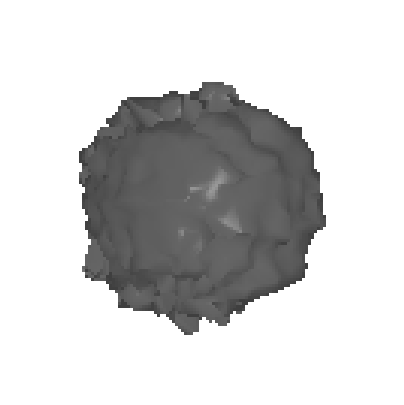

Epoch [500/2500], Loss: 7.3213


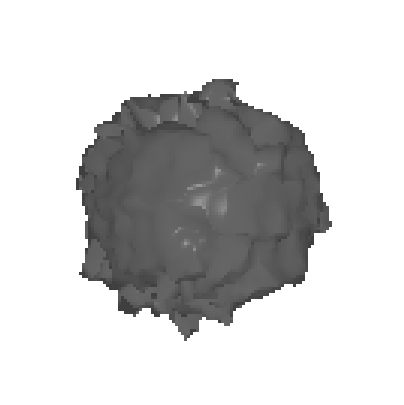

Epoch [600/2500], Loss: 2.2585


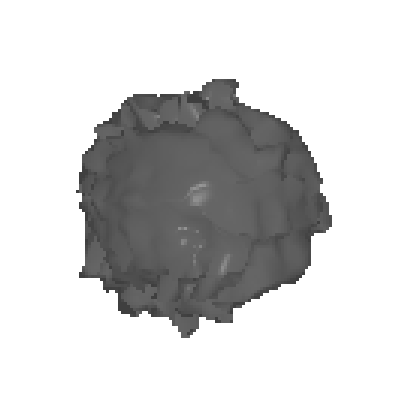

Epoch [700/2500], Loss: 0.2645


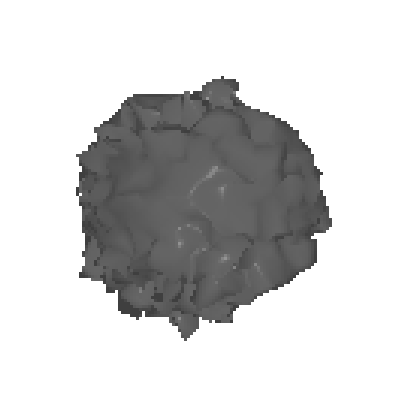

Epoch [800/2500], Loss: 0.2315


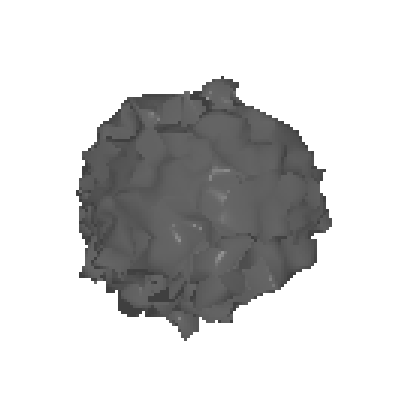

Epoch [900/2500], Loss: 0.8061


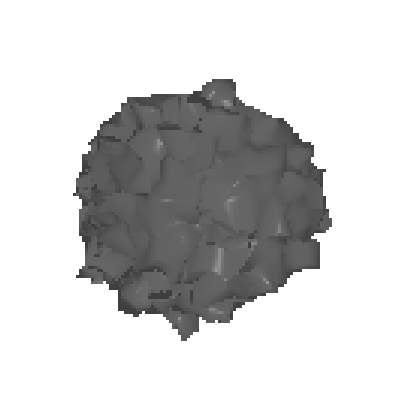

Epoch [1000/2500], Loss: 0.4377


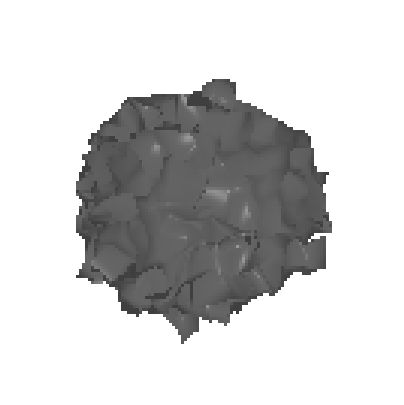

Epoch [1100/2500], Loss: 1.0524


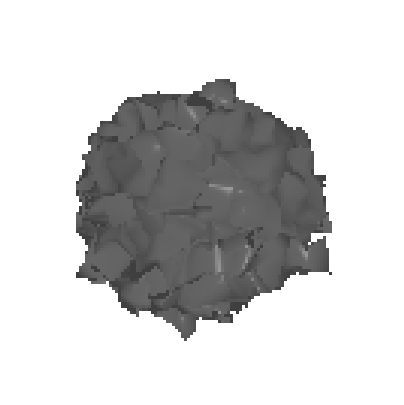

Epoch [1200/2500], Loss: 0.4043


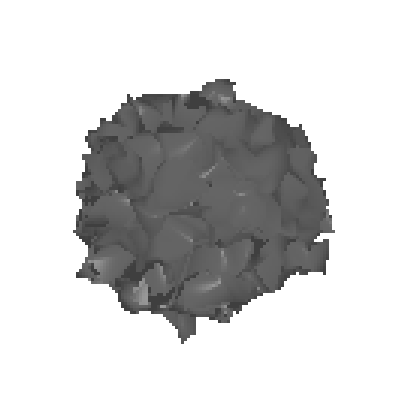

Epoch [1300/2500], Loss: 0.9492


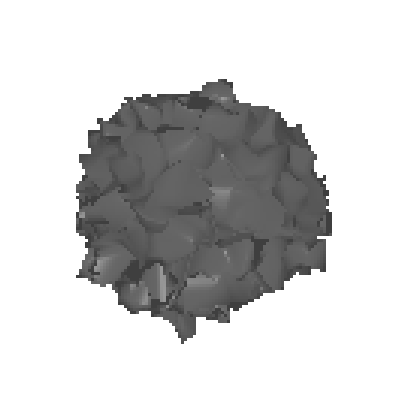

Epoch [1400/2500], Loss: 0.1658


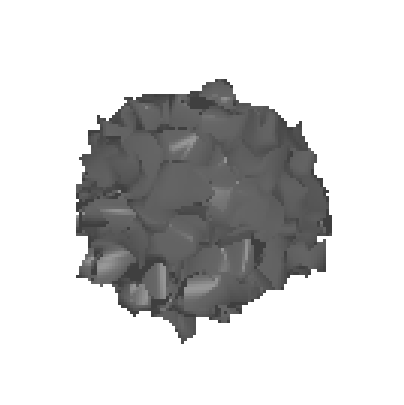

Epoch [1500/2500], Loss: 0.3160


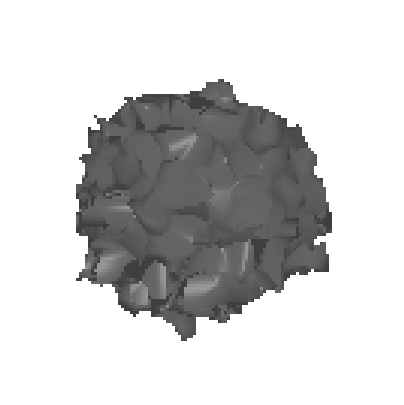

Epoch [1600/2500], Loss: 0.2445


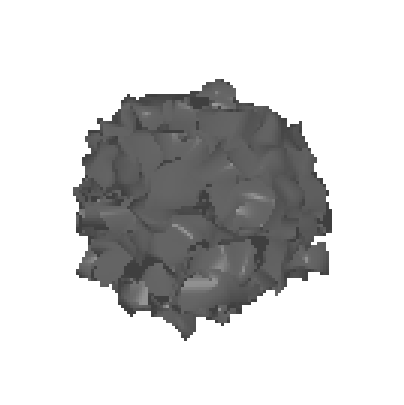

Epoch [1700/2500], Loss: 0.1665


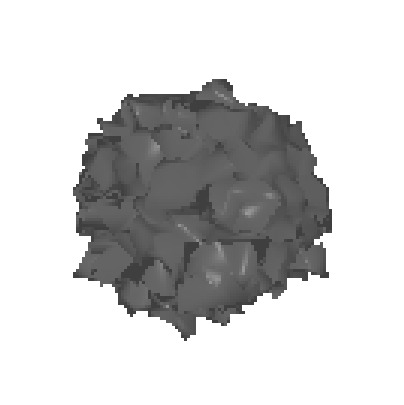

Epoch [1800/2500], Loss: 0.4502


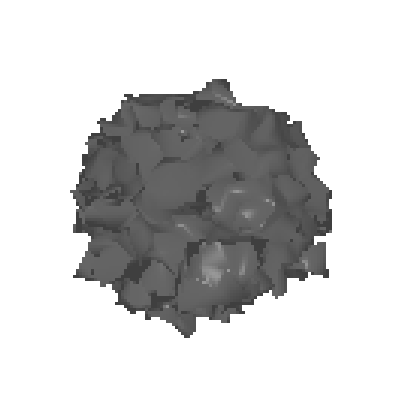

Epoch [1900/2500], Loss: 0.2504


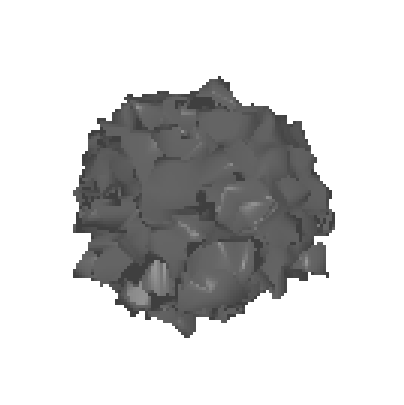

Epoch [2000/2500], Loss: 0.1595


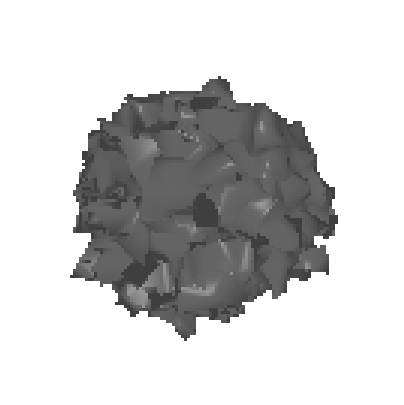

Epoch [2100/2500], Loss: 0.1911


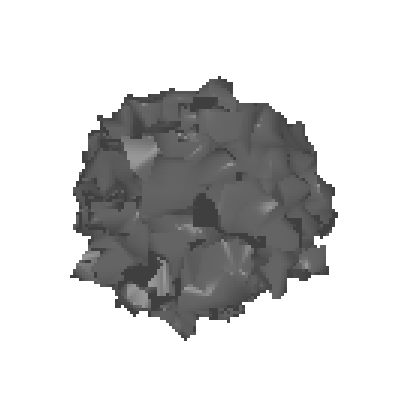

Epoch [2200/2500], Loss: 0.1322


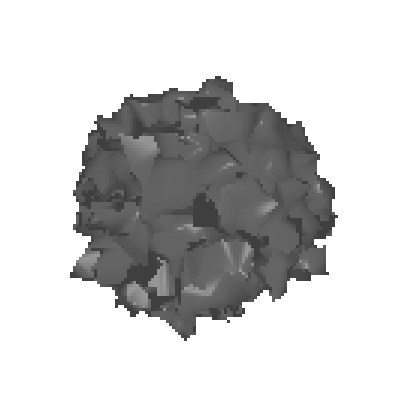

Epoch [2300/2500], Loss: 0.6733


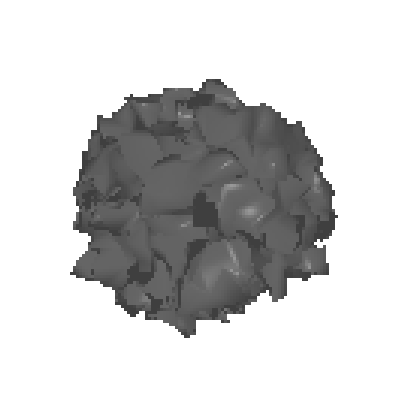

Epoch [2400/2500], Loss: 1.3900


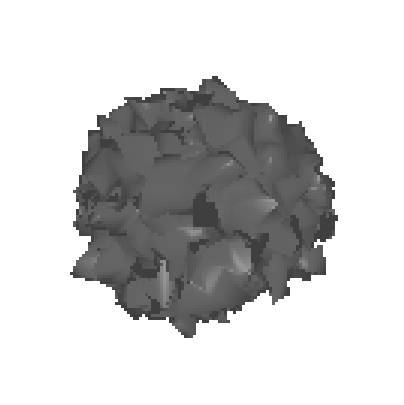

Epoch [2500/2500], Loss: 0.1421


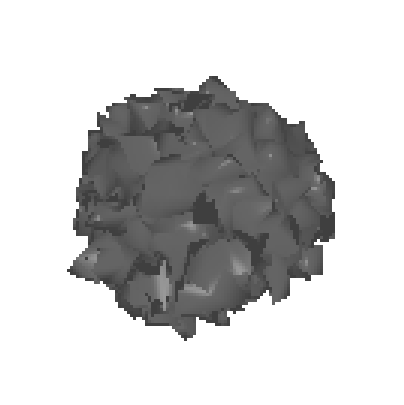

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, deform_verts, renderer, cameras, lights, num_epochs=2500, batch_size=16, use_smoothing_loss=True)

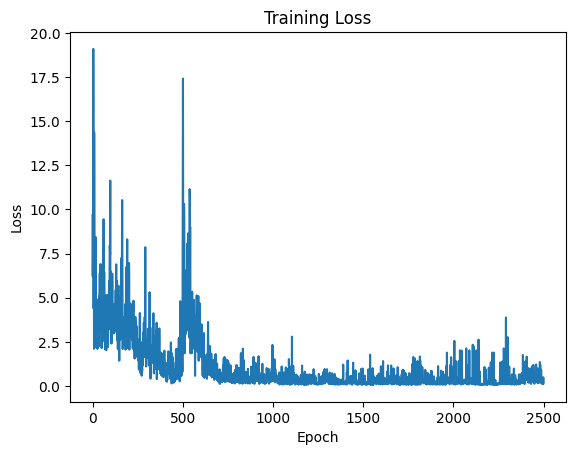

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
deformed_sphere_mesh = sphere_mesh.clone().offset_verts(deform_verts)

In [ ]:
num_tests=500
rmse = test_model(model, deformed_sphere_mesh, renderer, cameras, lights, num_tests=500)
print(f"Root mean squared error over {num_tests} tests: {rmse:.2f} (degrees).")

Root mean squared error over 500 tests: 22.15 (degrees).


# Experiments - color and shape optimization

In [ ]:
def train_model(model, optimizer, mesh, vertex_colors, deform_verts, renderer, cameras, lights, num_epochs=500, batch_size=32, lr=0.001, criterion=nn.MSELoss(), use_smoothing_loss=False):
  losses = []
  for epoch in range(num_epochs):
    total_loss = 0

    for i in range(batch_size):
      optimizer.zero_grad()

      deformed_mesh = mesh.clone().offset_verts(deform_verts)

      textures = TexturesVertex(verts_features=vertex_colors.clone())
      deformed_mesh.textures = textures

      angle = np.random.randint(0, 360)
      rotated_sphere = create_rotated_sphere(deformed_mesh, angle, device)

      image = renderer(rotated_sphere, cameras=cameras, lights=lights)
      image = image[..., :3].contiguous().permute(0, 3, 1, 2)

      predicted_angle = model(image)
      target_angle = torch.tensor([[angle * np.pi / 180.0]], device=device)

      loss = criterion(predicted_angle, target_angle)
      if use_smoothing_loss:
          loss += mesh_laplacian_smoothing(deformed_mesh, method="uniform")  # Add weight to the smoothing loss? How much?

      loss.backward()

      total_loss += loss.item()

    avg_epoch_loss = total_loss / batch_size
    losses.append(avg_epoch_loss)
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
        deformed_mesh = mesh.clone().offset_verts(deform_verts)
        visualize_sphere(deformed_mesh, vertex_colors, renderer, cameras, lights)

  return losses

## Optimizing the colors, shape and weights simultaneously

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.repeat(verts.shape[0], 1)
vertex_colors = nn.Parameter(vertex_colors.unsqueeze(0))

textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)  # Preuzeto s https://pytorch3d.org/tutorials/deform_source_mesh_to_target_mesh

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [deform_verts], 'lr': 0.001},
    {'params': [vertex_colors], 'lr': 0.001}
], lr=0.001)

criterion = nn.MSELoss()

Epoch [100/2500], Loss: 4.7091


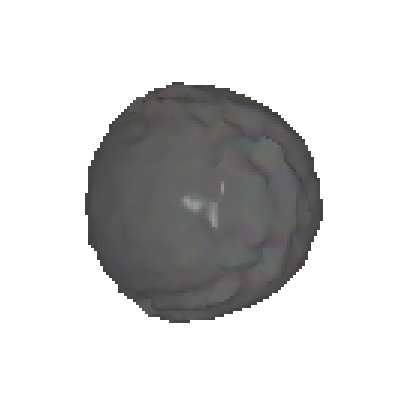

Epoch [200/2500], Loss: 0.5348


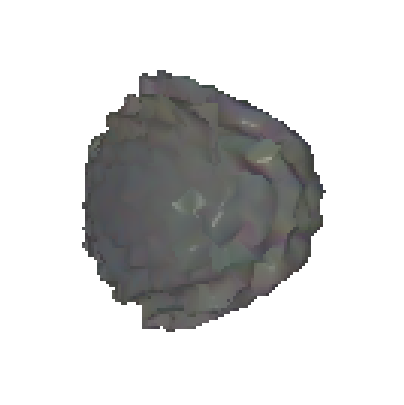

Epoch [300/2500], Loss: 0.5077


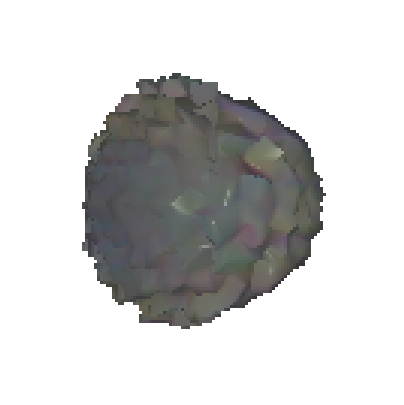

Epoch [400/2500], Loss: 0.5864


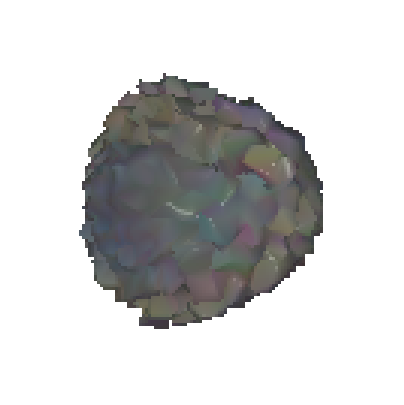

Epoch [500/2500], Loss: 0.3110


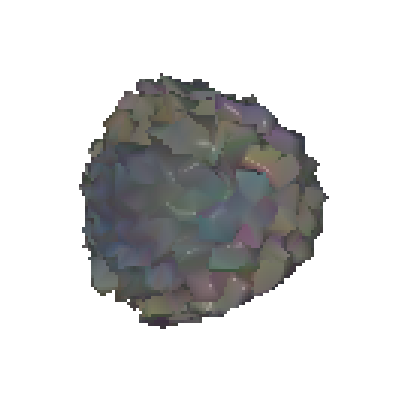

Epoch [600/2500], Loss: 0.0889


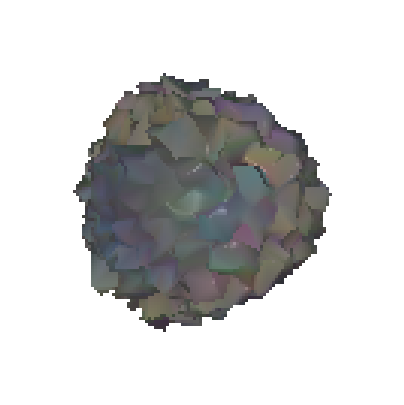

Epoch [700/2500], Loss: 0.4783


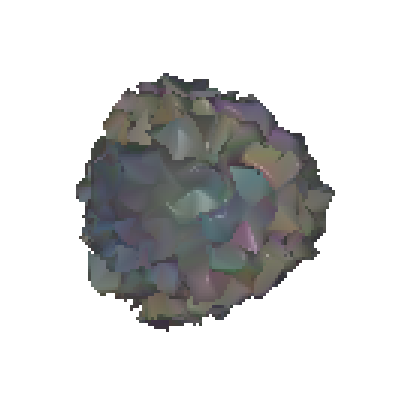

Epoch [800/2500], Loss: 1.4108


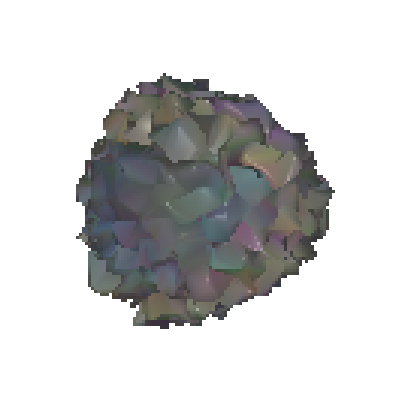

Epoch [900/2500], Loss: 0.7508


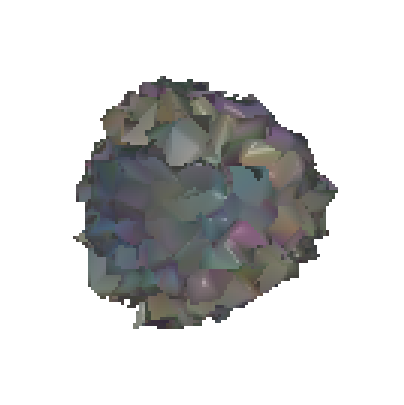

Epoch [1000/2500], Loss: 0.1922


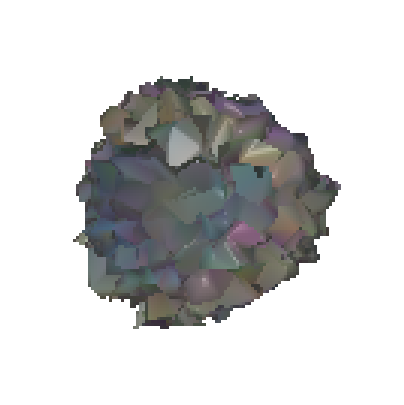

Epoch [1100/2500], Loss: 0.0541


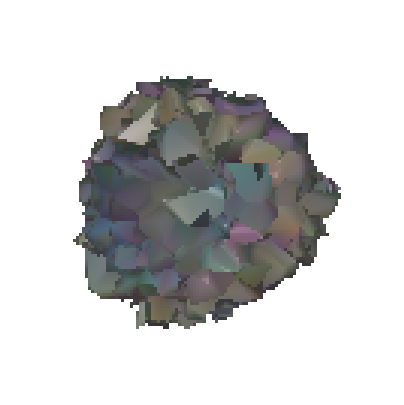

Epoch [1200/2500], Loss: 0.1401


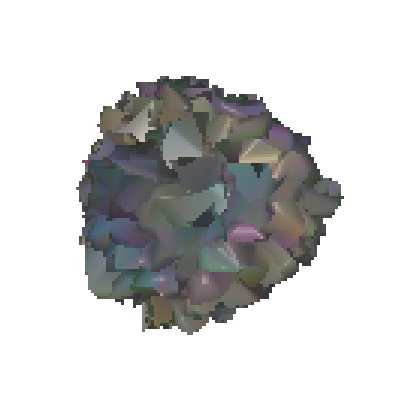

Epoch [1300/2500], Loss: 0.0917


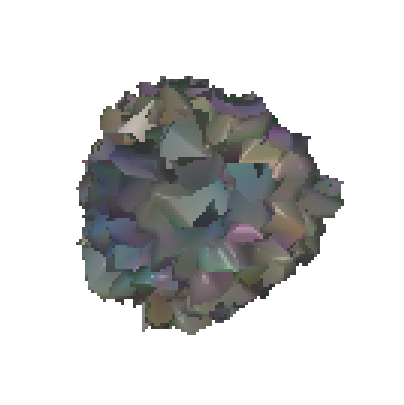

Epoch [1400/2500], Loss: 0.7809


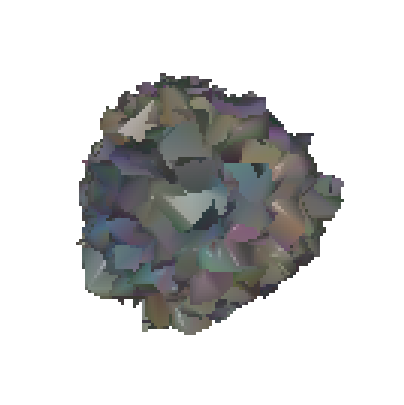

Epoch [1500/2500], Loss: 0.0084


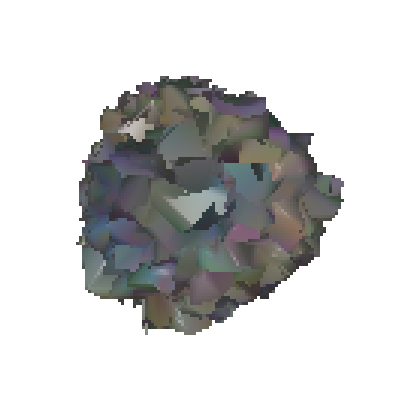

Epoch [1600/2500], Loss: 0.2844


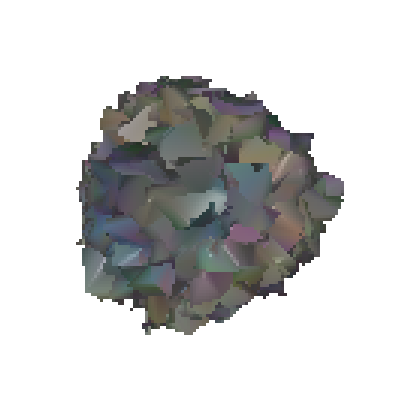

Epoch [1700/2500], Loss: 0.3104


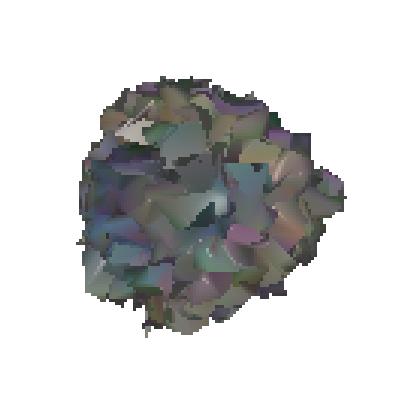

Epoch [1800/2500], Loss: 0.3162


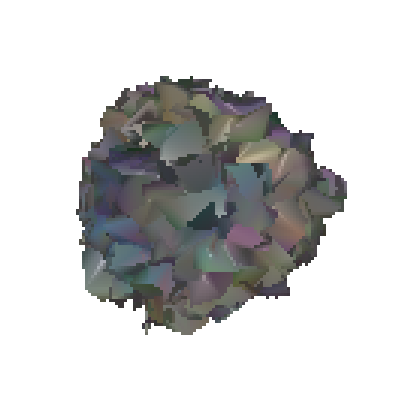

Epoch [1900/2500], Loss: 0.0239


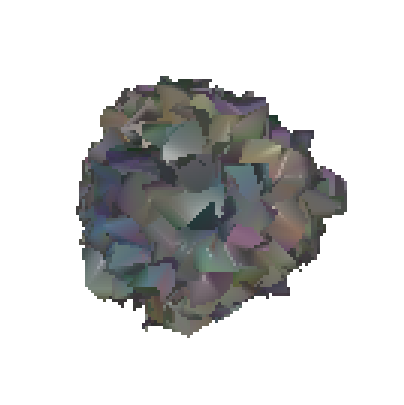

Epoch [2000/2500], Loss: 1.0220


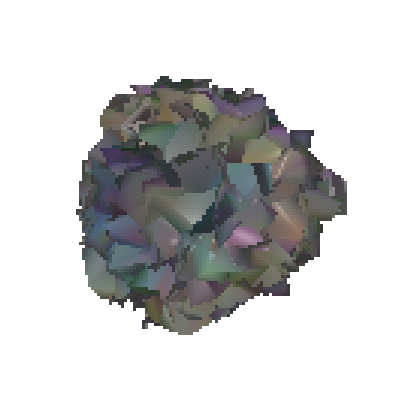

Epoch [2100/2500], Loss: 1.3137


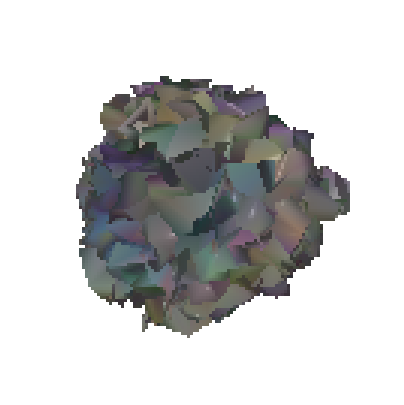

Epoch [2200/2500], Loss: 0.2522


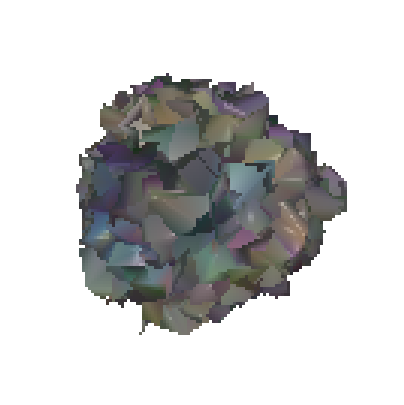

Epoch [2300/2500], Loss: 0.0519


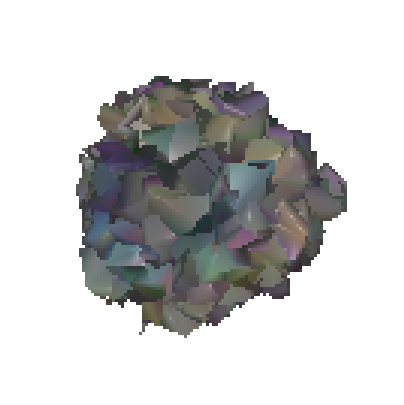

Epoch [2400/2500], Loss: 0.1873


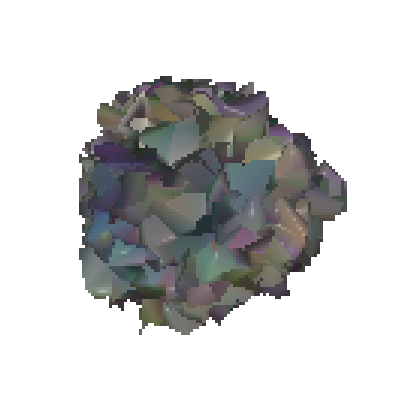

Epoch [2500/2500], Loss: 0.1027


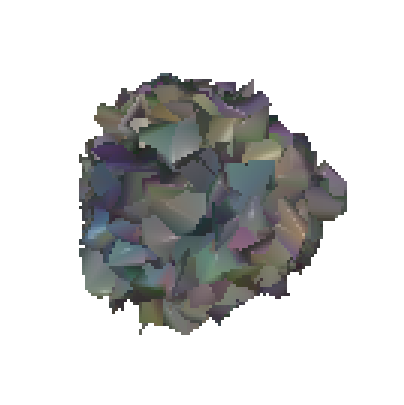

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, vertex_colors, deform_verts, renderer, cameras, lights, num_epochs=2500, batch_size=16)

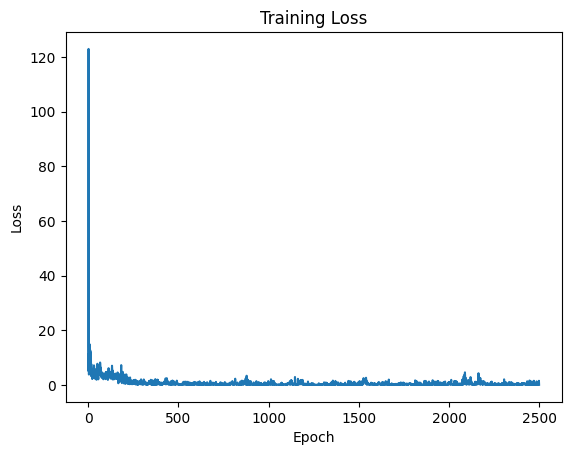

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
deformed_sphere_mesh = sphere_mesh.clone().offset_verts(deform_verts)

In [ ]:
num_tests=500
rmse = test_model(model, deformed_sphere_mesh, renderer, cameras, lights, num_tests=500)
print(f"Root mean squared error over {num_tests} tests: {rmse:.2f} (degrees).")

Root mean squared error over 500 tests: 31.81 (degrees).


## Optimizing the colors, shape and weights simultaneously with smoothing

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.repeat(verts.shape[0], 1)
vertex_colors = nn.Parameter(vertex_colors.unsqueeze(0))

textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)  # Preuzeto s https://pytorch3d.org/tutorials/deform_source_mesh_to_target_mesh

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [deform_verts], 'lr': 0.001},
    {'params': [vertex_colors], 'lr': 0.001}
], lr=0.001)

criterion = nn.MSELoss()

Epoch [100/2500], Loss: 2.5247


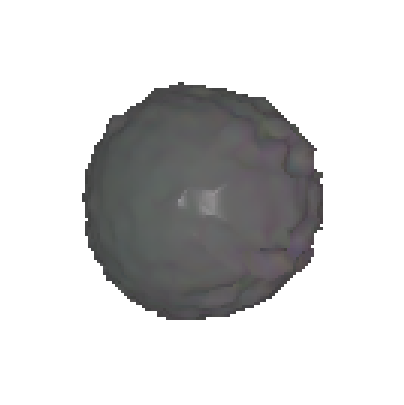

Epoch [200/2500], Loss: 1.5259


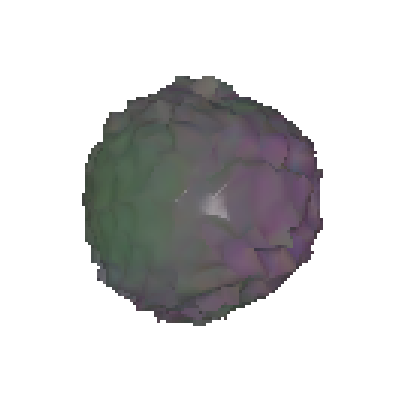

Epoch [300/2500], Loss: 0.5952


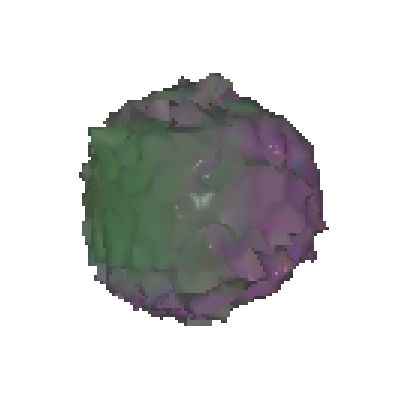

Epoch [400/2500], Loss: 0.5151


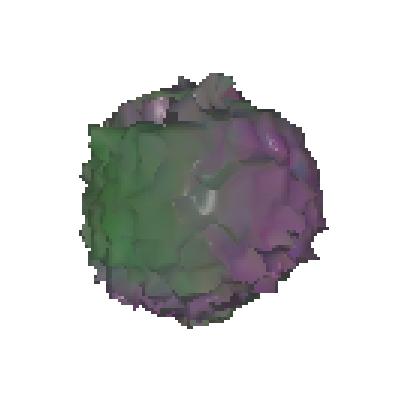

Epoch [500/2500], Loss: 1.0673


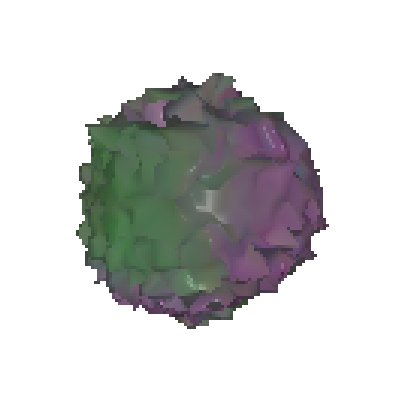

Epoch [600/2500], Loss: 0.5914


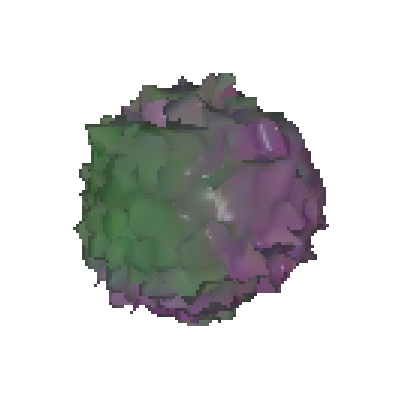

Epoch [700/2500], Loss: 0.6914


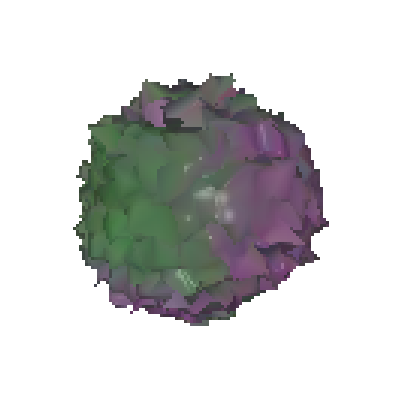

Epoch [800/2500], Loss: 0.4094


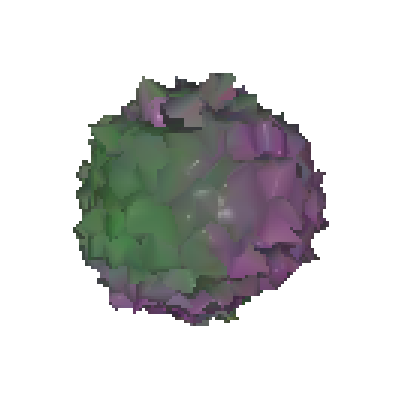

Epoch [900/2500], Loss: 0.0688


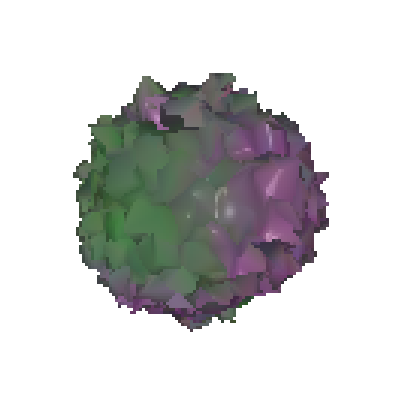

Epoch [1000/2500], Loss: 0.2303


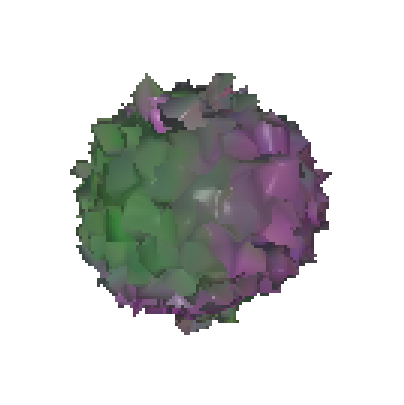

Epoch [1100/2500], Loss: 0.4222


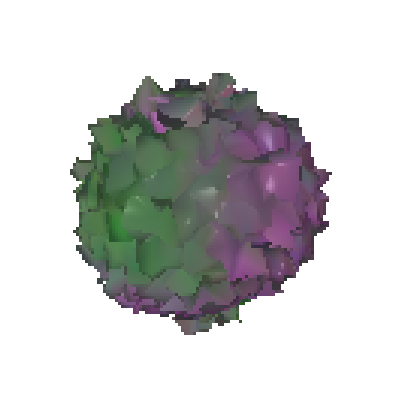

Epoch [1200/2500], Loss: 0.0172


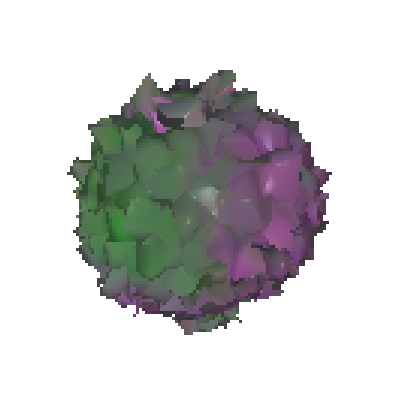

Epoch [1300/2500], Loss: 0.5767


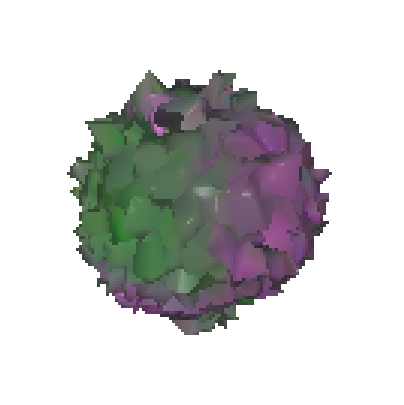

Epoch [1400/2500], Loss: 0.0781


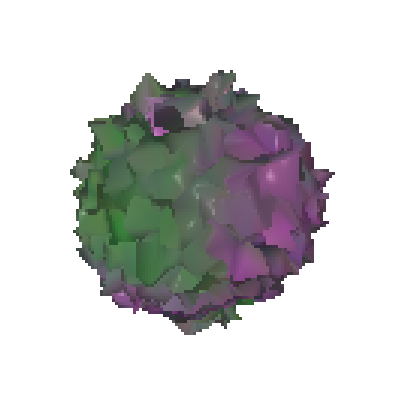

Epoch [1500/2500], Loss: 0.4942


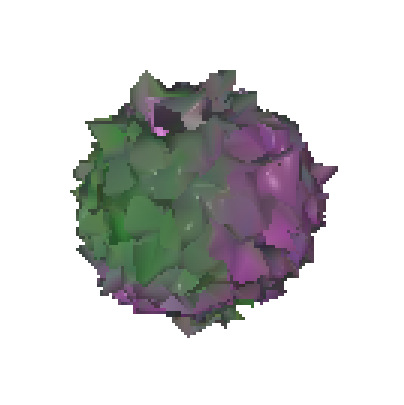

Epoch [1600/2500], Loss: 0.1549


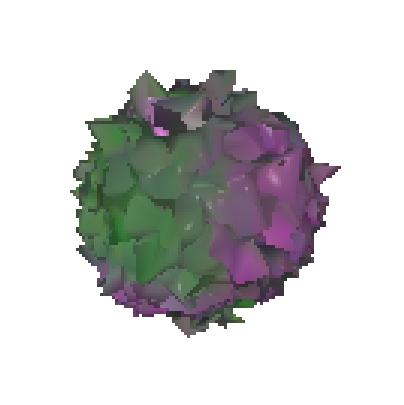

Epoch [1700/2500], Loss: 0.9008


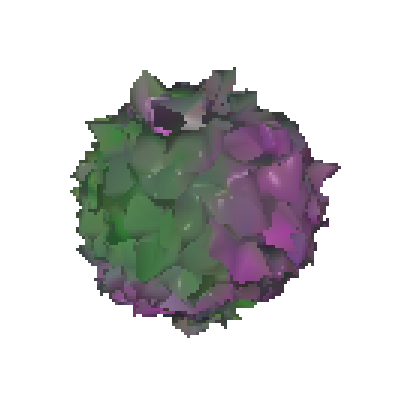

Epoch [1800/2500], Loss: 0.5459


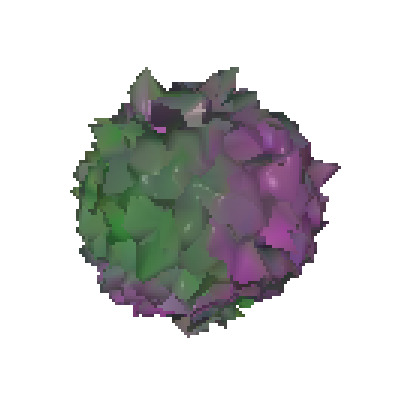

Epoch [1900/2500], Loss: 0.0657


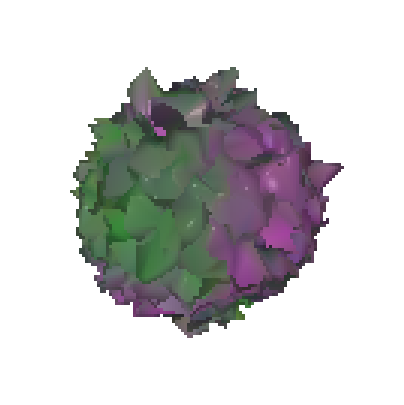

Epoch [2000/2500], Loss: 0.0679


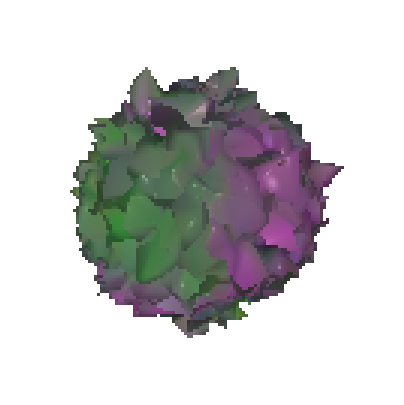

Epoch [2100/2500], Loss: 0.7992


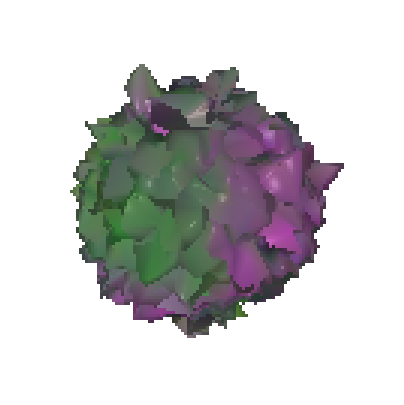

Epoch [2200/2500], Loss: 0.1165


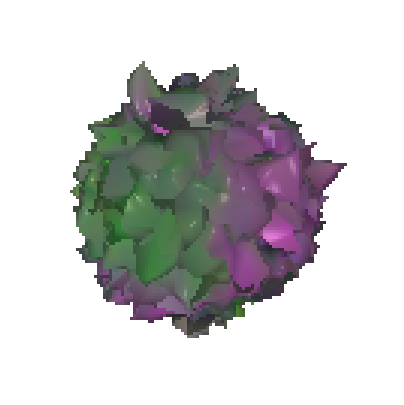

Epoch [2300/2500], Loss: 0.0887


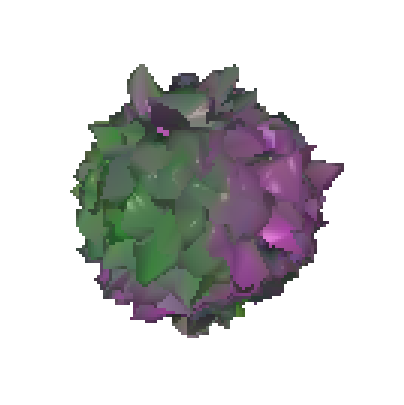

Epoch [2400/2500], Loss: 0.0212


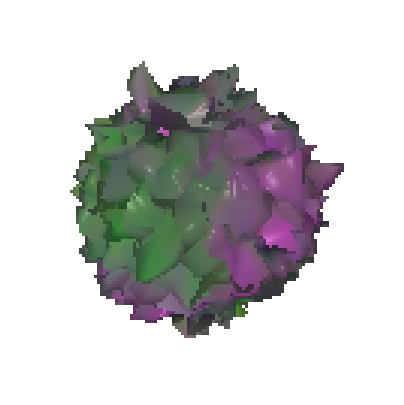

Epoch [2500/2500], Loss: 0.4453


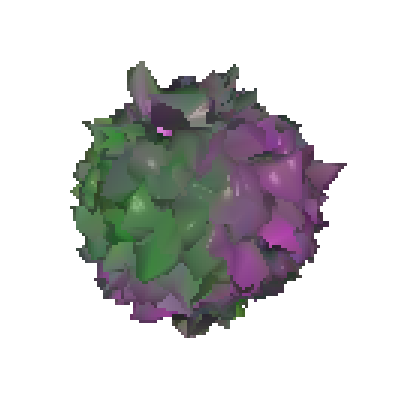

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, vertex_colors, deform_verts, renderer, cameras, lights, num_epochs=2500, batch_size=16)

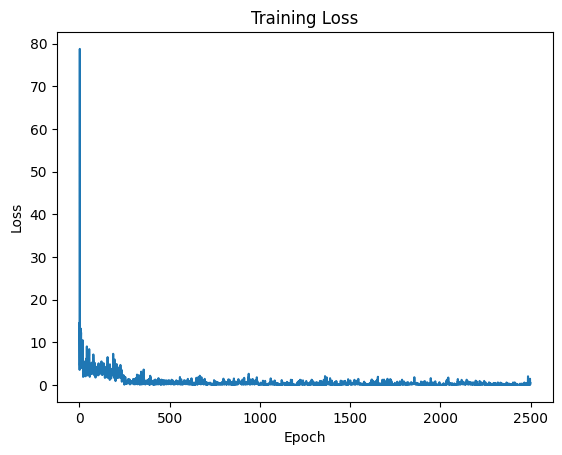

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
deformed_sphere_mesh = sphere_mesh.clone().offset_verts(deform_verts)

In [ ]:
num_tests=500
rmse = test_model(model, deformed_sphere_mesh, renderer, cameras, lights, num_tests=500)
print(f"Root mean squared error over {num_tests} tests: {rmse:.2f} (degrees).")

Root mean squared error over 500 tests: 25.40 (degrees).
